# 0.0 Imports

In [1]:
# Data manipulate
import numpy as np
import pandas as pd
import seaborn as sns
import psycopg2 as pg
import scikitplot as skplt
from pycorrcat import pycorrcat
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Model Selection and Data preparation
from boruta import BorutaPy
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

# ML and Metrics
from xgboost import XGBClassifier
from sklearn import ensemble as en
from sklearn import neighbors as nh
from lightgbm import LGBMClassifier
from imblearn import ensemble as ien
from sklearn import linear_model as lm
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# Fine tunning
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver

# Others
import pickle
import warnings
from tabulate import tabulate
from IPython.display import Image
from numerize import numerize as nm
from credentials.credentialsdb import acess

f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 Helper Functions

In [2]:
def notebook_settings():
    '''Define configurations for notebook, matplotlib and Pandas.'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignora future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()


def precision_recall_at_k( data, k=20000 ):
    '''
    Calculate metrics of precision and recall for an total number of rankings (k)
    return tuple of precision and recall, return dataframe with ranking
    '''
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return ((data.loc[k, 'precision_at_k'], data.loc[k, 'recall_at_k']), data)


def gain_lift_curve(yhat, yval, plot = True, axvline='None'):
    '''
    plots gain and lift curve, respectively
    returns the curves and a table used to plot the curves
    '''

    # create table proba with the propensity score for each class (0 and 1)
    table_proba = pd.DataFrame(yhat)

    # add the 'response' column
    table_proba['response'] = yval.values

    # add the 'correct' column to evaluate wheter the prediction was right or not
    x = lambda x: "yes" if x[0] > x[1] and x['response'] == 0 else "yes" if x[1] > x[0] and x['response'] == 1 else "yes" if x[0] == x[1] else "no" 
    table_proba['correct'] = table_proba.apply(x, axis = 1)

    # order by propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('response').count().loc[1,1]

    ## apply a score for every row which response is 1
    x = lambda x: 1/qty_class_1 if x['response'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(8, 10))

        # gap between graphics
        fig.tight_layout(pad =5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_propensity_score'], label='cumulative (model)', linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_porc_base'], label='baseline', linewidth = 2.5, color = 'black' )
        axes[0].lines[1].set_linestyle("--")
        axes[0].legend()
        axes[0].set_title('cumulative gains curve')
        axes[0].set_xlabel('percentage of sample')
        axes[0].set_ylabel('gain')

        if axvline != 'None':
            axes[0].axvline(axvline, 0, 1, color='green', ls='--', lw=2)

        # lift curve
        ## do not consider the beginning of the series, as it varies a lot (the sample is still small)
        table_proba_filtered = table_proba.query('cumulative_porc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = table_proba_filtered['lift'], label='model', linewidth = 2.5 );
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = np.ones(len(table_proba_filtered)), label='baseline', linewidth = 2.5, color = 'black' )
        axes[1].lines[1].set_linestyle("--")
        axes[1].legend()
        axes[1].set_title('lift curve')
        axes[1].set_xlabel('percentage of sample')

        if axvline != 'None':
            axes[1].axvline(axvline, 0, 1, color='green', ls='--', lw=2)
        
        plt.show();
        
    return (table_proba)


def runCrossValidation(model, x_train, y_train, n_splits, n_repeats=1, top_k = 20000, verbose=False):
    '''
    Make cross validation with parameters of total ranking (k)
    return a dataframe with metrics of precision and recall at k
    '''
    # local import
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.model_selection import RepeatedStratifiedKFold

    
    if verbose:
        # the lenght_msg is to print only once a specific message
        length_msg = True
        i = 1

    
    # definition of the cross-validation strategy
    # - the "n_splits" parameter is the number of folds (k)
    # - the "n_repeats" parameter is the number of times cross-validator needs to 
    #   be repeated
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats )
    
    precision_at_k = []
    recall_at_k = []
    b_accuracy_score = []

    x = x_train
    y = y_train
    
    for train_index, prim_val_index in cv.split(x, y):      
        x_training, x_prim_val = x.iloc[train_index], x.iloc[prim_val_index]
        y_training, y_prim_val = y.iloc[train_index], y.iloc[prim_val_index]
        
        if (verbose == True) and (length_msg == True):
            print(f'training_lenght:{x_training.shape[0]}\nvalidation_lenght:{x_prim_val.shape[0]}\n\n')
            length_msg = False
        
        if verbose:
            print(f'Iteration number:{i}')
            i += 1

        # fit and predict/predict_proba
        model.fit(x_training, y_training)
        yhat_proba = model.predict_proba(x_prim_val)
        yhat_prob = model.predict(x_prim_val)

        
        # get results
        table = gain_lift_curve(yhat_proba,y_prim_val, plot = False)
        metrics, new_table = precision_recall_at_k(table, top_k)
        ba_knn = balanced_accuracy_score(y_prim_val, yhat_prob)
        metrics = (*metrics, ba_knn)
        
        if verbose:
            print(metrics)
            print('')
        
        # save the metrics value to the list
        precision_at_k.append(metrics[0])
        recall_at_k.append(metrics[1])
        b_accuracy_score.append(metrics[2])
        
    df_results = pd.DataFrame([[np.mean(precision_at_k),np.std(precision_at_k)], 
                       [np.mean(recall_at_k), np.std(recall_at_k)], [np.mean(b_accuracy_score), np.std(b_accuracy_score)]], 
                      columns = ['mean', 'std'])
    
    df_results.index = ['precision_at_k', 'recall_at_k', 'accuracy_score']
    
    return(df_results)

In [3]:
notebook_settings()

## 0.2 Load Data

In [4]:
# Credentials
host = acess.get('host')
port = acess.get('port')
database = acess.get('database')
username = acess.get('username')
password = acess.get('password')

# acess database
conn = pg.connect(user=username,
                  password = password,
                  host = host,
                  port = port,
                  database = database)

# make a cursor into database
cursor = conn.cursor()

# verify all schemas
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
    """

cursor.execute(query_schema)
record = cursor.fetchall()
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',),
 ('pg_temp_4',),
 ('pg_toast_temp_4',),
 ('pa005',),
 ('pg_temp_9',),
 ('pg_toast_temp_9',)]

In [5]:
# Verify tables from the schema
#query_tables = """
#    SELECT tablename
#    FROM pg_tables
#    WHERE schemaname='pa004'
#    """

#cursor.execute(query_tables)
#record = cursor.fetchall()
#record

In [6]:
# Collect tables into dataframe
query_tables_insurance = """
    SELECT *
    FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                       INNER JOIN pa004.insurance i ON (u.id = i.id)
    """

df_raw = pd.read_sql(query_tables_insurance, conn)

# close connection into database
cursor.close()
conn.close()

# 1.0 Descrição dos dados

In [7]:
df1 = df_raw.copy()

In [8]:
# drop duplicates id columns
df1 = df1.loc[:, ~df1.columns.duplicated()].copy()
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.000,152.000,1,< 1 Year,Yes,0,23367.000,249,0
1,13,Female,41,15.000,14.000,1,1-2 Year,No,1,31409.000,221,0
2,18,Female,25,35.000,152.000,1,< 1 Year,No,1,46622.000,299,0
3,31,Female,26,8.000,160.000,1,< 1 Year,No,0,2630.000,136,0
4,39,Male,45,8.000,124.000,1,1-2 Year,Yes,0,42297.000,264,0


## 1.2 Data Dimension

In [9]:
print(f'Number os rows: {df1.shape[0]}')
print(f'Number os cols: {df1.shape[1]}')

Number os rows: 381109
Number os cols: 12


## 1.3 Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [13]:
# Central tendency and Dispersion
d1 = pd.DataFrame (num_attributes.apply( lambda x: x.max() - x.min() )).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate
m2 = pd.concat([d1, d2]).T.reset_index()
m2.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
m2 = m2[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

m2

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,381109.000,381108.000,190555.000,190555.000,110016.836,-0.000,-1.200
1,age,20.000,85.000,65.000,38.823,36.000,15.512,0.673,-0.566
2,region_code,0.000,52.000,52.000,26.389,28.000,13.230,-0.115,-0.868
3,policy_sales_channel,1.000,163.000,162.000,112.034,133.000,54.204,-0.900,-0.971
4,driving_license,0.000,1.000,1.000,0.998,1.000,0.046,-21.595,464.354
5,previously_insured,0.000,1.000,1.000,0.458,0.000,0.498,0.168,-1.972
6,annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,17213.155,1.766,34.005
7,vintage,10.000,299.000,289.000,154.347,154.000,83.671,0.003,-1.201
8,response,0.000,1.000,1.000,0.123,0.000,0.328,2.302,3.299


### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

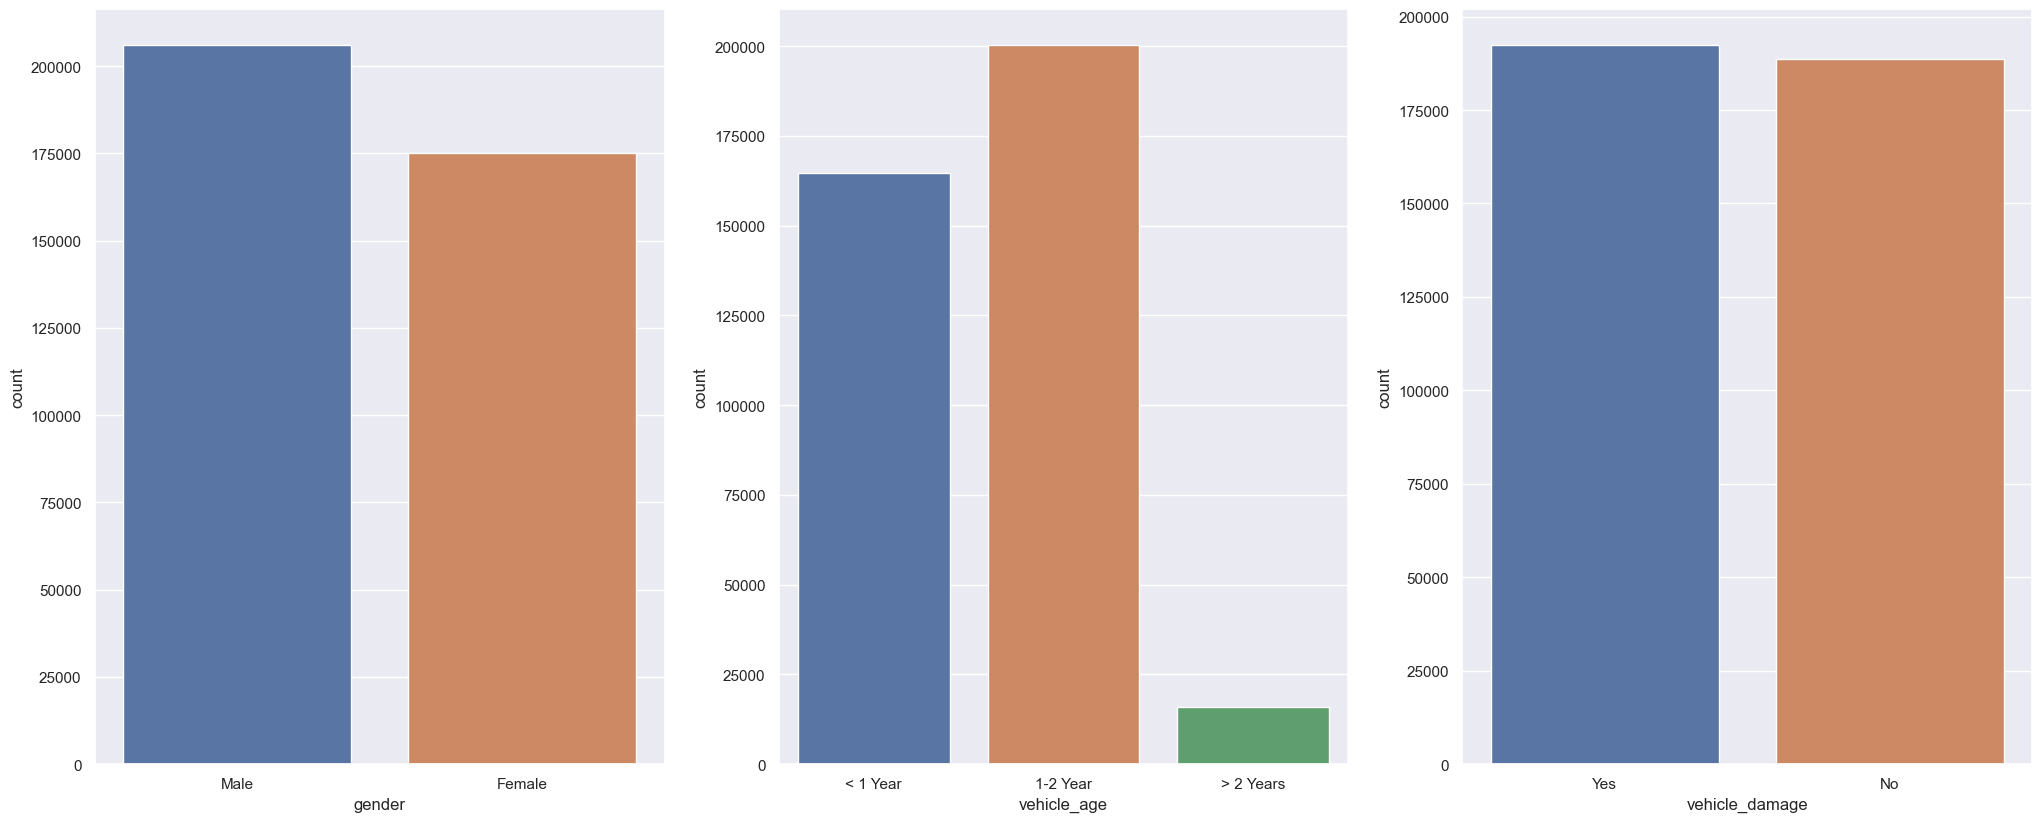

In [15]:
plt.subplot (1, 3, 1)
sns.countplot(x='gender', data=df1)

plt.subplot (1, 3, 2)
sns.countplot(x='vehicle_age', data=df1)

plt.subplot (1, 3, 3)
sns.countplot(x='vehicle_damage', data=df1);

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

## 2.1 MindMap Hypothesis

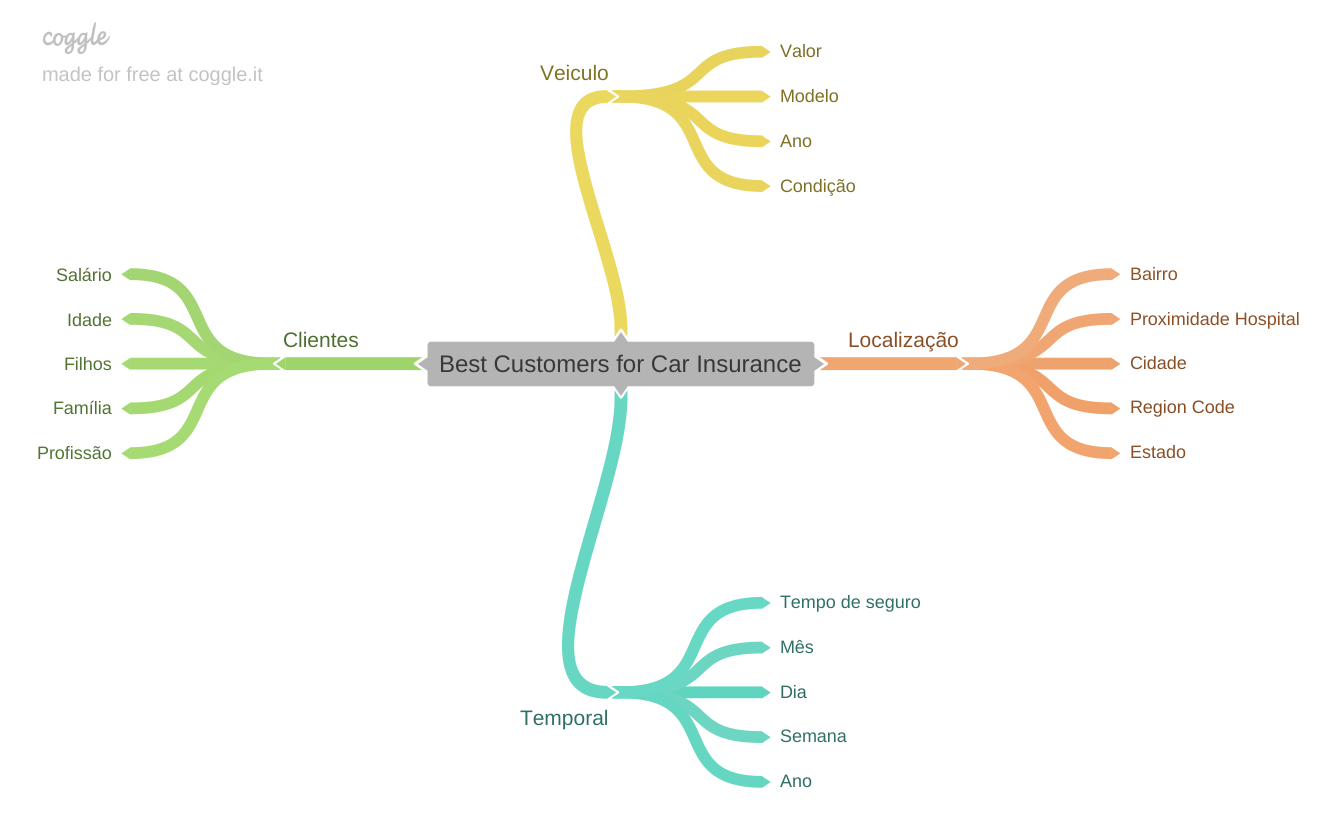

In [17]:
Image('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/reports/figures/Best_Customers_for_Car_Insurance.png')

## 2.1.1 Hipóteses Veiculo

**1.** Pessoas que possuem carro mais caros possuem maior interesse em seguro

**2.** Pessoas com carros de modelo popular possuem menos interesse em seguro

**3.** Pessoas com carros comprados recentemente possuem maior interesse em seguro

**4.** Pessoas que o carro já foi danificado possuem maior interesse em seguro em relação aos que não foram danificados


## 2.1.2 Hipóteses Cliente

**1.** Pessoas com maiores salarios possuem mais interesse em seguros

**2.** Pessoas mais velhas possuem maior interesse em seguro

**3.** Pessoas com filhos possuem maior interesse em seguro

**4.** Pessoas com familia possuem maior interesse em seguro 

## 2.1.3 Hipóteses Localização

**1.** Pessoas próximas de hospitais possuem mais interesse em seguro

**2.** Pessoas em diferentes regiões possuem maior interesse em seguro

## 2.1.4 Hipóteses Tempo

**1.** Pessoas com mais tempo com seguro tem maior interesse em outros seguros

**2.** Pessoas possuem maior interesse em seguro no inverno.

**3.** Pessoas possuem maior interesse em seguro nos dias de feriado

**4.** Existe maior interesse em seguros com o passar dos anos.

## 2.2 Lista final de hipóteses

**1.** Pessoas com carros comprados recentemente possuem maior interesse em seguro

**2.** Pessoas que o carro já foi danificado possuem maior interesse em seguro

**3.** Pessoas mais velhas possuem maior interesse em seguro

**4.** Pessoas em melhores regiões possuem maior interesse em seguro

**5.** Pessoas com mais tempo com seguro tem maior interesse em outros seguros

## 2.3 Feature Engineering

In [18]:
# adjust format into vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years'
                                                        else 'between_1_2_year' if x == '1-2 Year'
                                                        else 'below_1_year')


# Convert categorical into numeric
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

# 3.0 Filtragem de variáveis

In [19]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [20]:
# select only annual_premium bellow 65.000
df3 = df3[df3['annual_premium'] < 65000]

## 3.2 Seleção das colunas

In [21]:
# Select only who has driving license
df3 = df3[df3['driving_license'] == 1]

# drop driving license column
df3.drop(columns='driving_license', inplace=True)

# 4.0 Análise exploratória dos dados

In [22]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

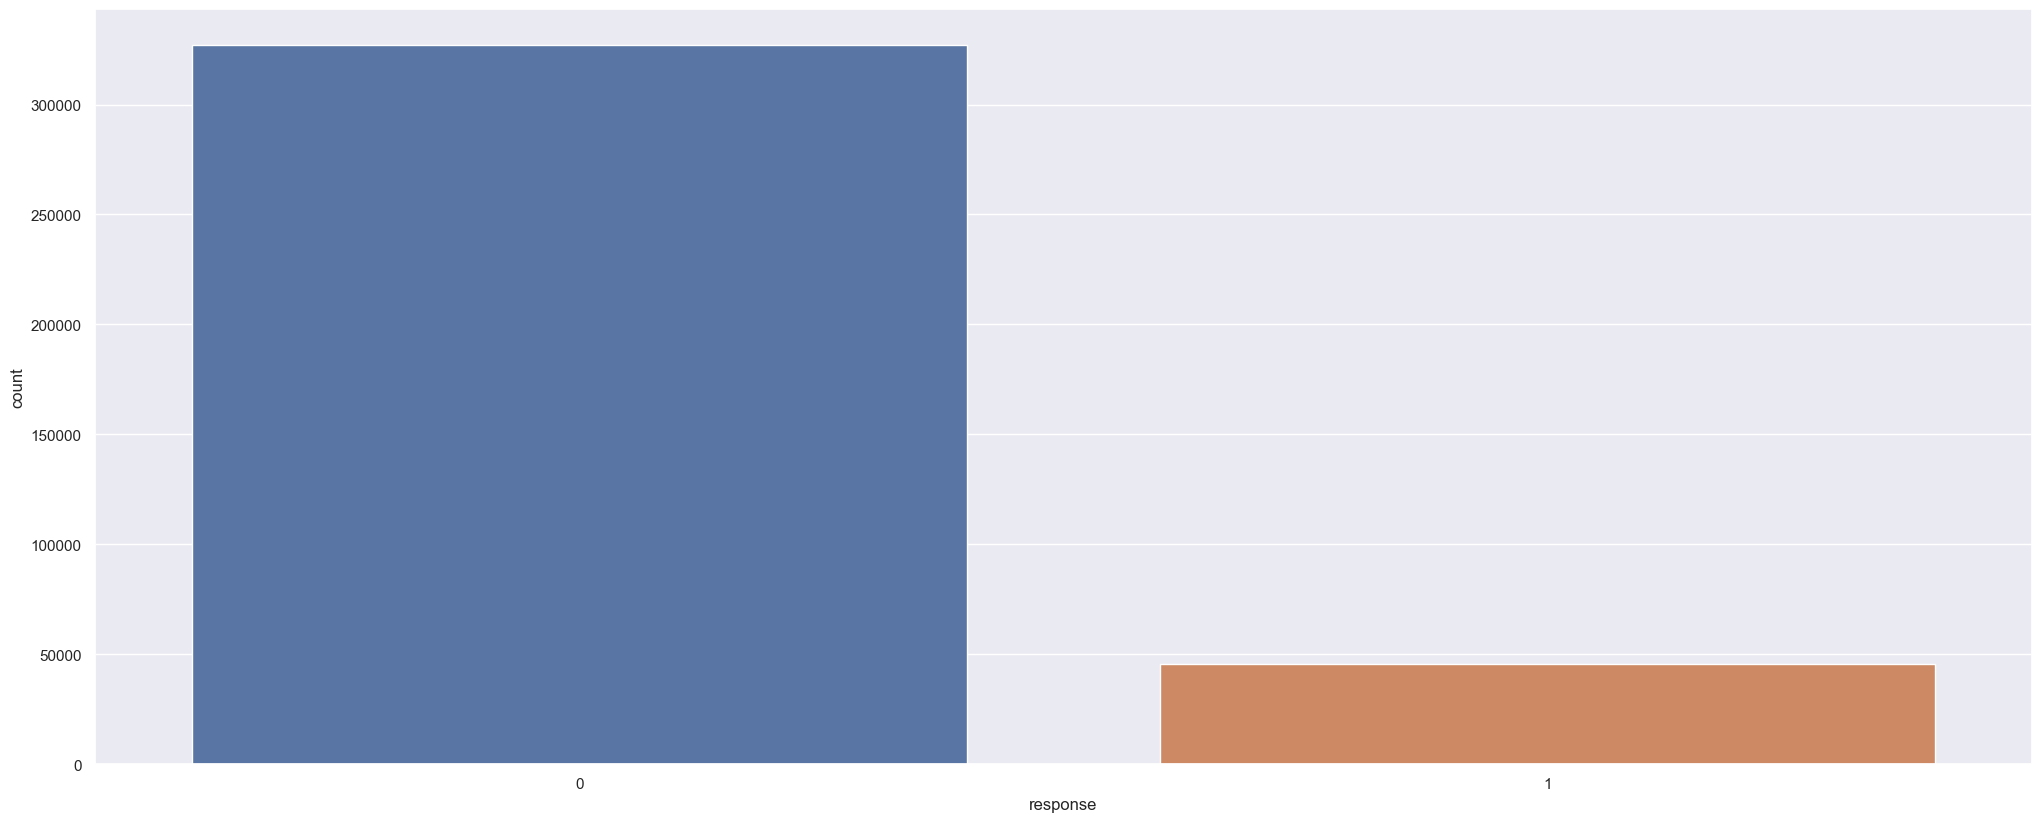

In [23]:
sns.countplot(x='response', data=df4);

### 4.1.2 Numerical Variable

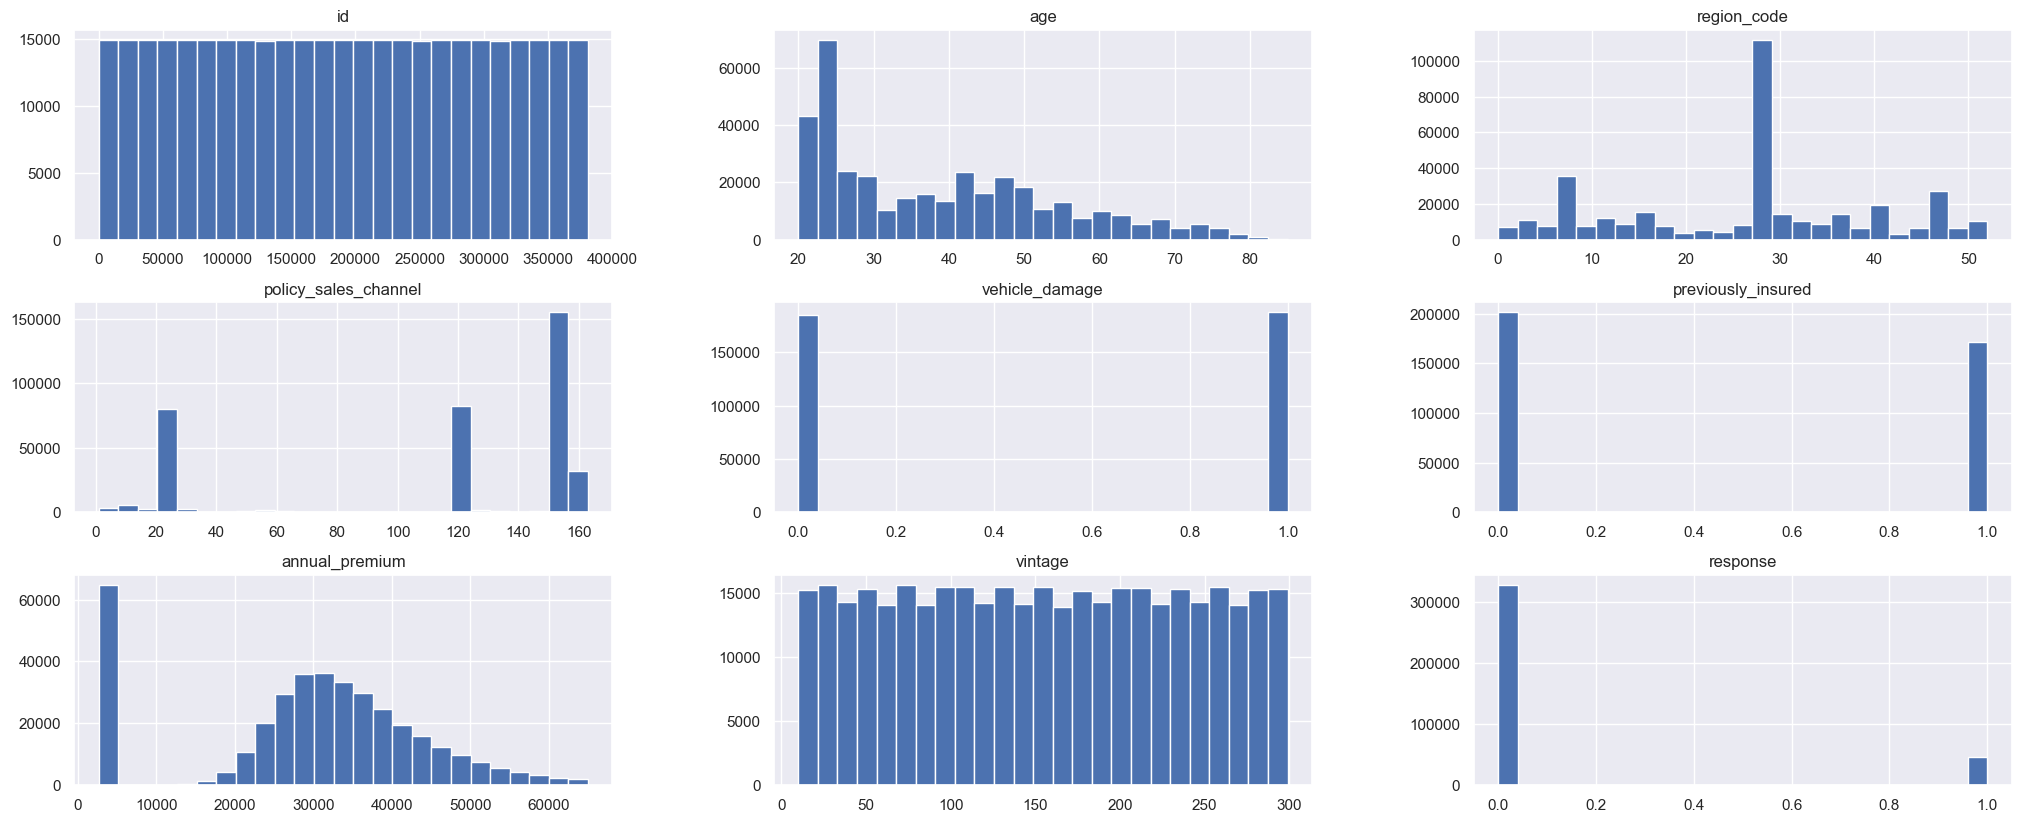

In [24]:
num_attributes = df4.select_dtypes(include='number')
num_attributes.hist(bins=25);

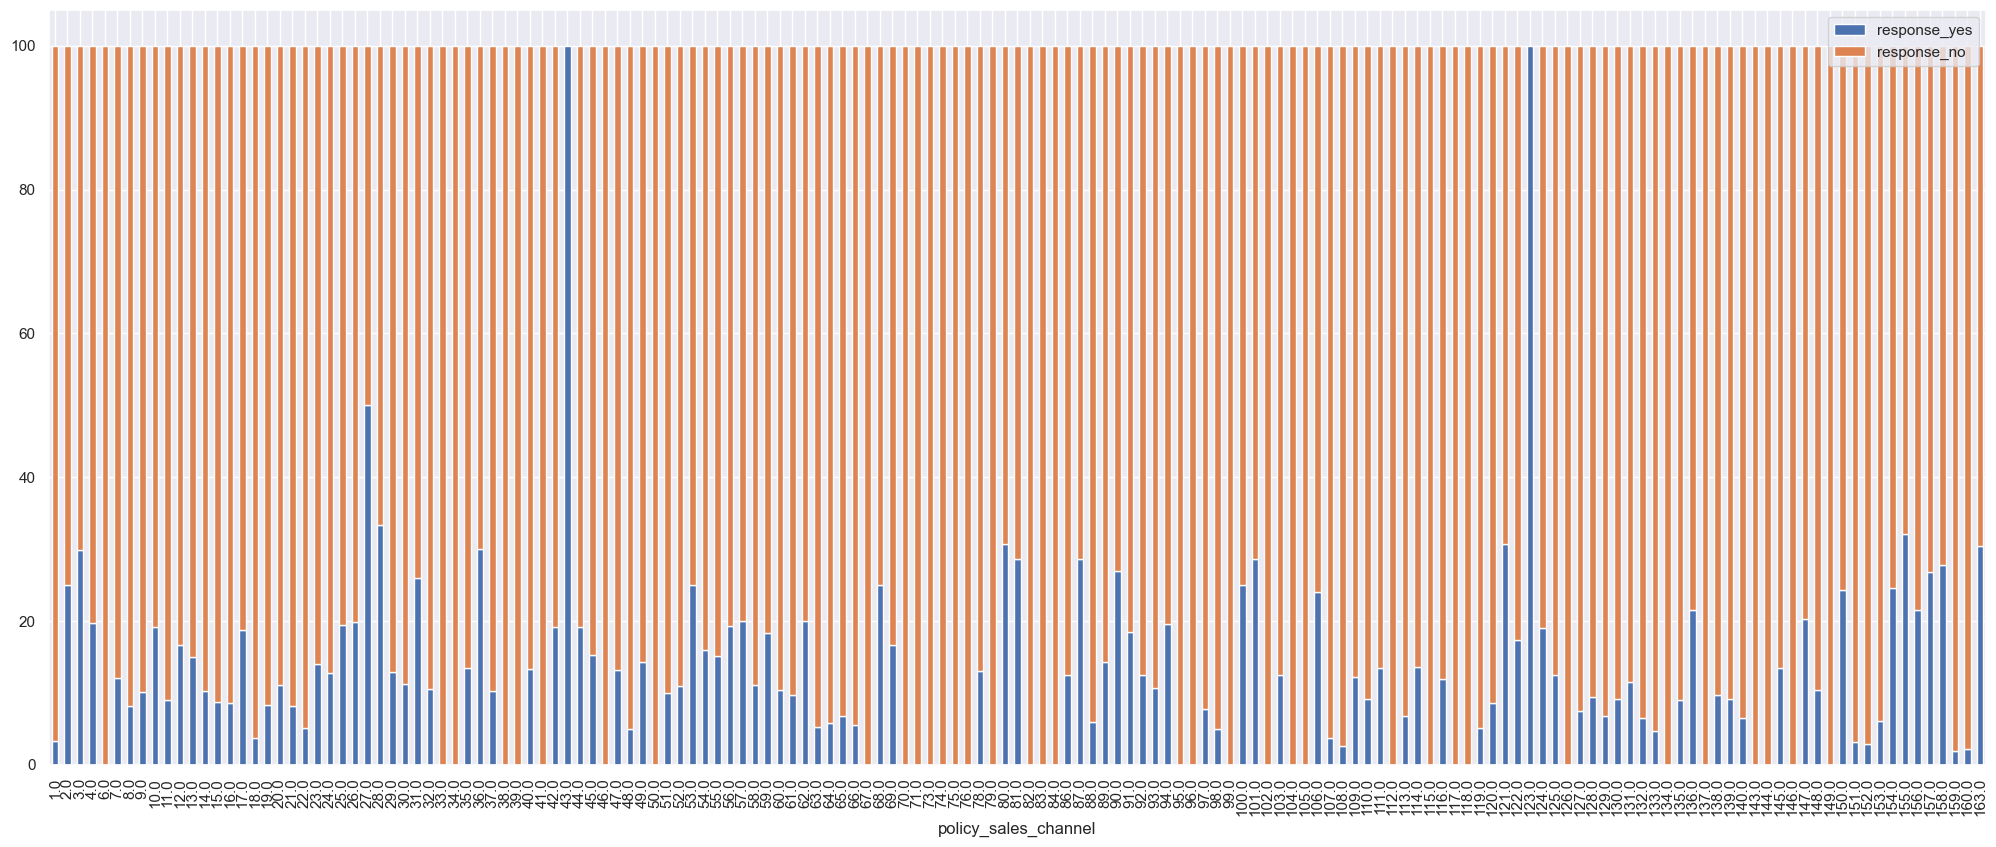

In [25]:
#policy_sales_channel
# count responses per channel
aux01 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index() # count responses = 1 per channel
aux02 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').count().reset_index() # count total responses

# merge and make percentage
aux03 = pd.merge(aux01, aux02, how='inner', on='policy_sales_channel') # merge data of responses
aux03['response_y'] = aux03.apply(lambda x: int(x['response_y'] - x['response_x']), axis=1) # adjust total response for response = 0

# transform into percentage
aux03['response_x'] = aux03.apply(lambda x: x['response_x']/(x['response_x'] + x['response_y']) * 100, axis=1)
aux03['response_y'] = aux03.apply(lambda x: 100 - x['response_x'], axis=1)

# adjust columns name
aux03.columns = ['policy_sales_channel', 'response_yes', 'response_no']

# plot
aux03.plot(x = 'policy_sales_channel', kind = 'bar', stacked = True);

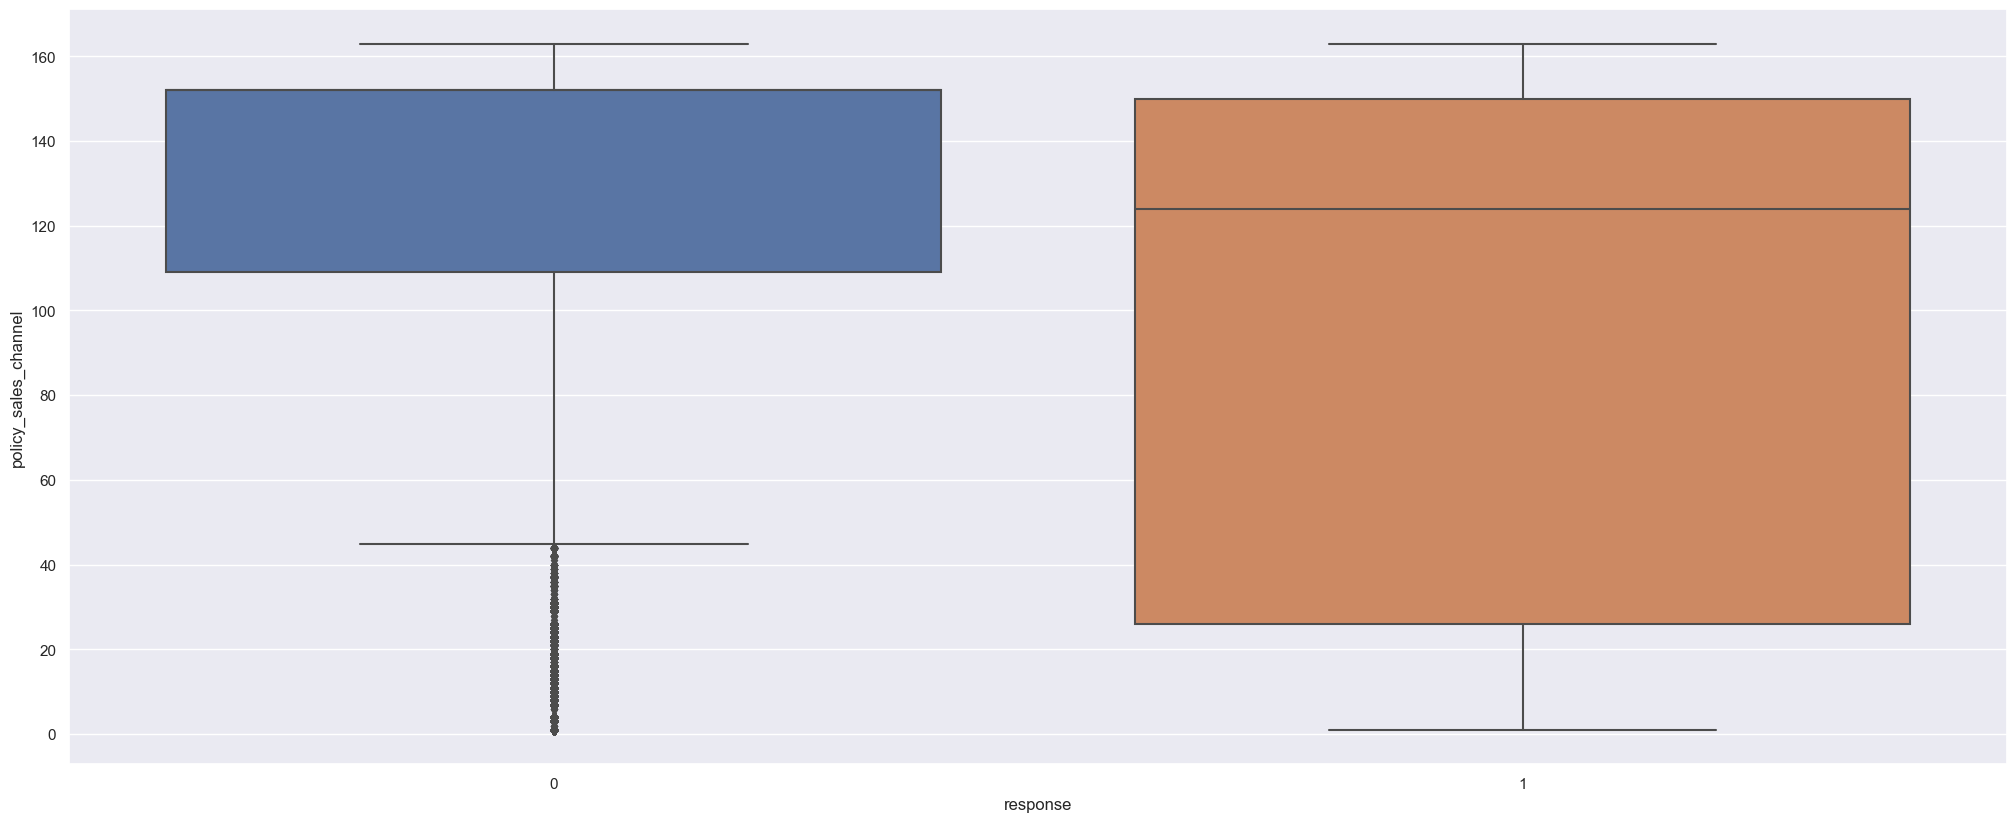

In [26]:
sns.boxplot(x='response', y='policy_sales_channel', data=df4);

In [27]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x : x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.775,0.225
1,0.999,0.001


### 4.1.3 Categorical Variable

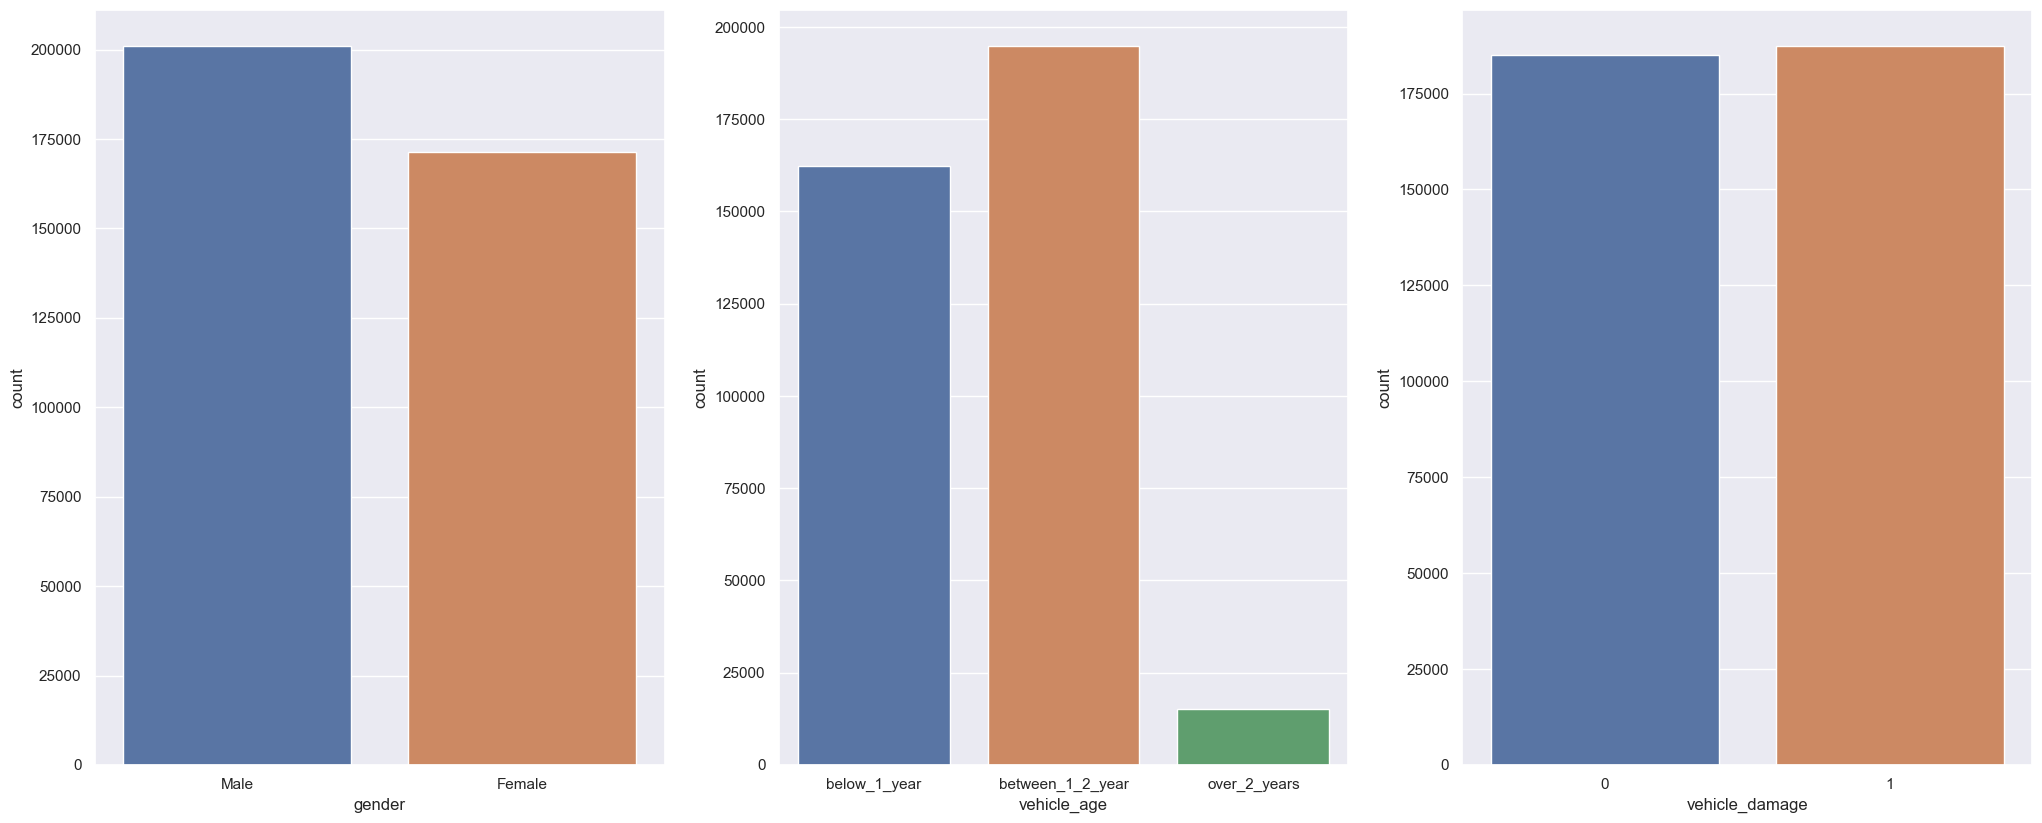

In [28]:
# gender
plt.subplot (1, 3, 1)
sns.countplot(x='gender', data=df4)

# vehicle_age
plt.subplot (1, 3, 2)
sns.countplot(x='vehicle_age', data=df4)

# vehicle_damage
plt.subplot (1, 3, 3)
sns.countplot(x='vehicle_damage', data=df4);

## 4.2 Análise Bivariada

### H1. Pessoas com carros comprados recentemente possuem maior interesse em seguro
**FALSA** Pessoas com carros antigos possuem maior interesse em seguro

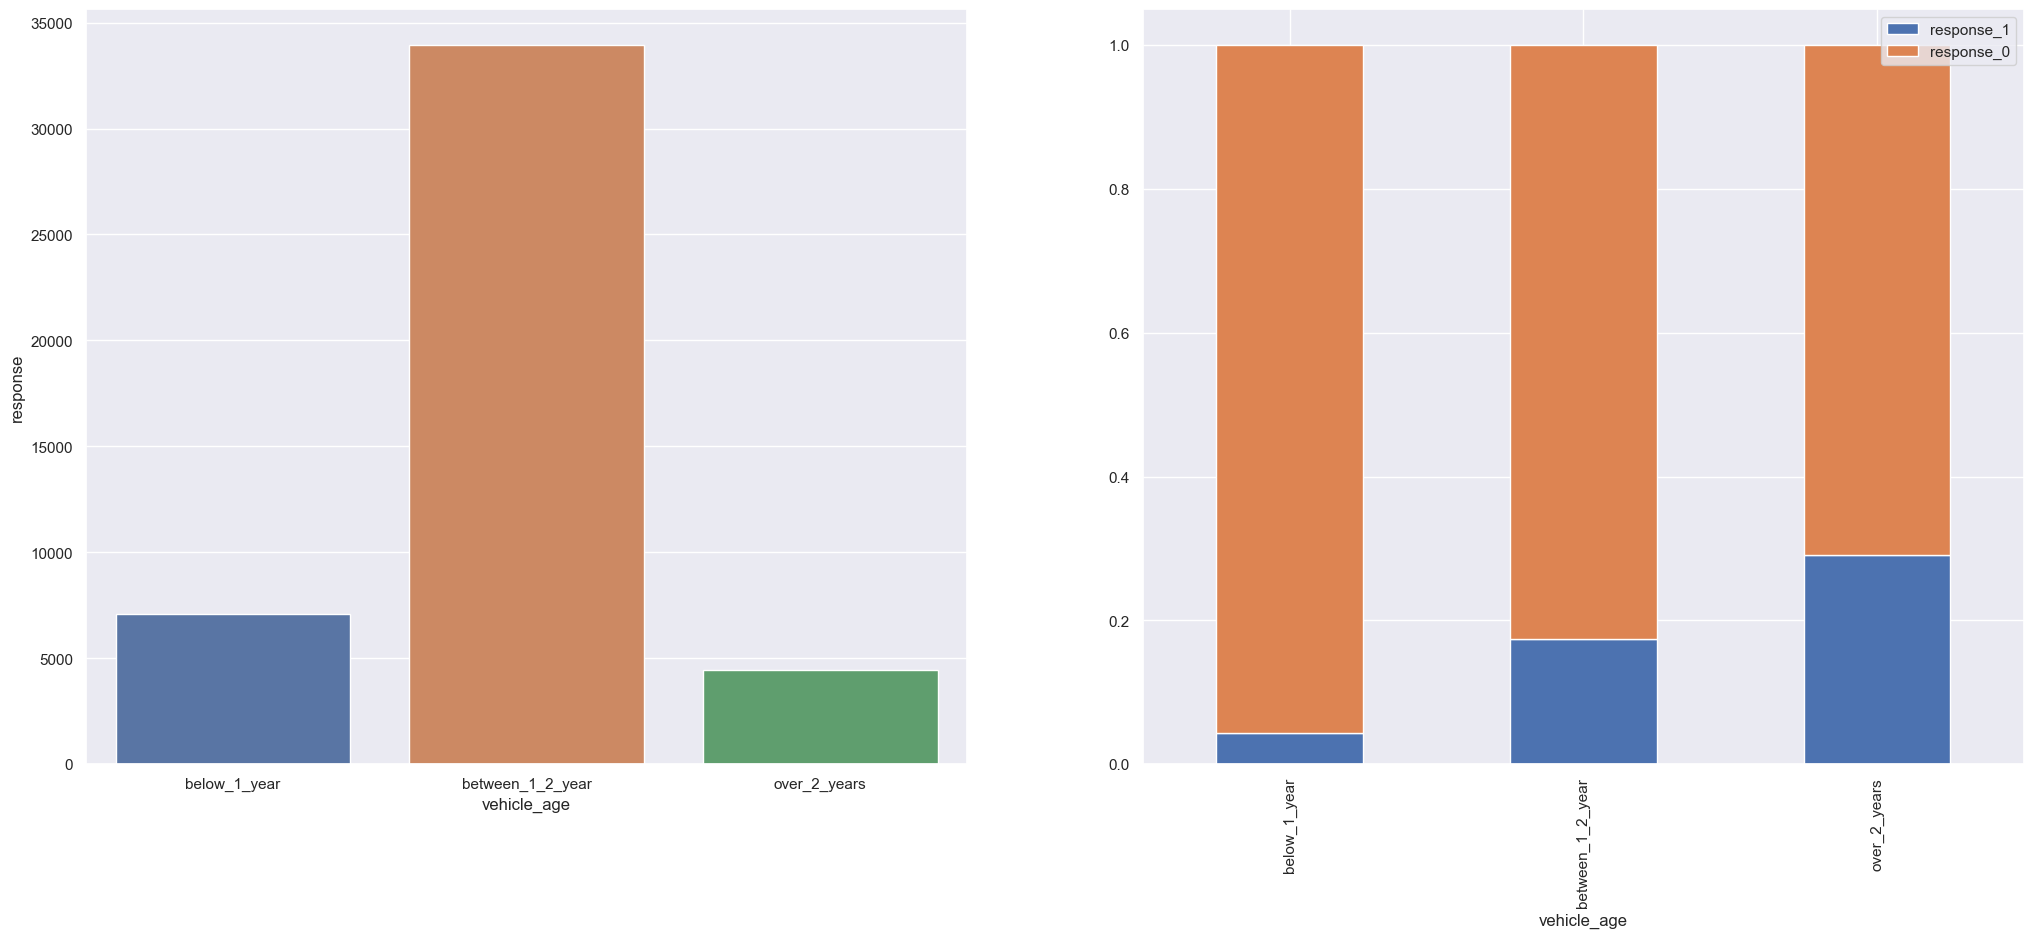

In [29]:
# plot for absolute response per vehicle age
plt.subplot(1, 2, 1)

aux01 = df4[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()
sns.barplot(x='vehicle_age', y='response', data=aux01);

# plot for percentages response per vehicle age
ax = plt.subplot(1, 2, 2)

aux02 = pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x / x.sum(), axis=1).reset_index()
columns = ['vehicle_age', 'response_0', 'response_1']
aux02.columns = columns
aux02 = aux02[['vehicle_age', 'response_1', 'response_0']]

aux02.plot(x = 'vehicle_age', kind = 'bar', stacked = True, ax=ax);

### H2. Pessoas que o carro já foi danificado possuem maior interesse em seguro em relação aos que não foram danificados
**VERDADEIRA** Pessoas que tiveram o carro danificado demontram maior interesse em seguro, entretanto a maioria ainda não prefere.

In [30]:
aux1 = pd.crosstab(df4['vehicle_damage'], df4['response'])
aux1.apply(lambda x: x / x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.995,0.005
1,0.763,0.237


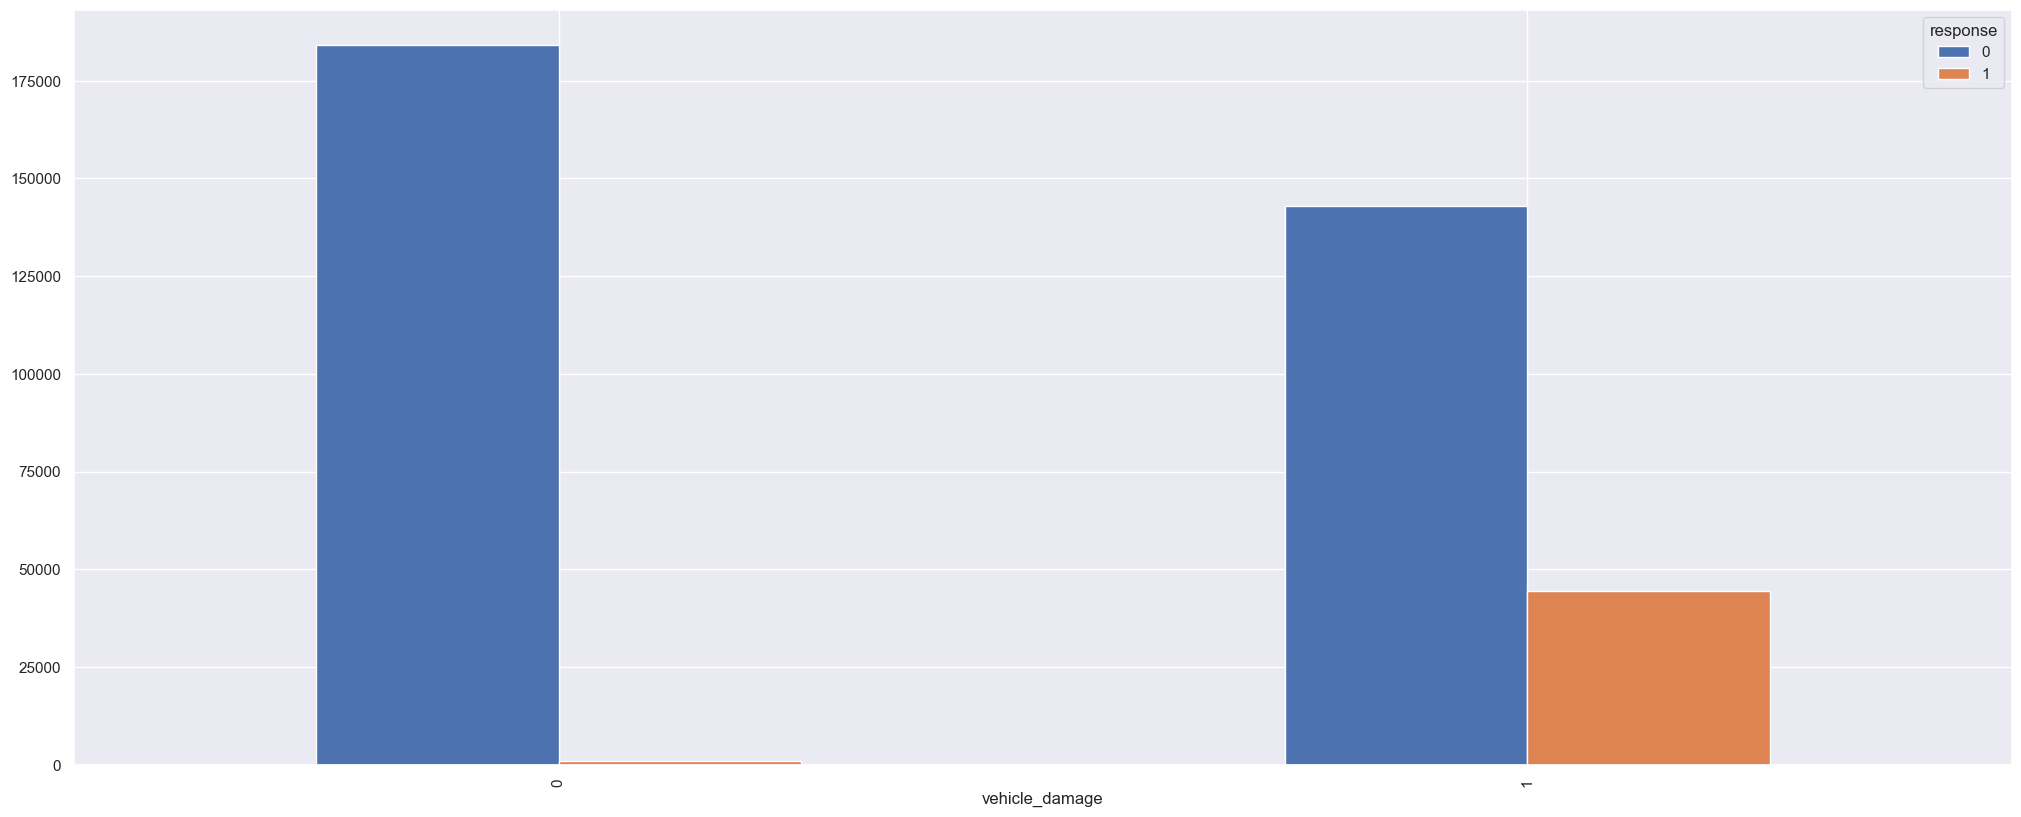

In [31]:
aux1.plot(kind='bar');

### H3. Pessoas mais velhas possuem maior interesse em seguro
**FALSO** Pessoas mais velhas possuem menor interesse em seguro a partir de 40 anos.

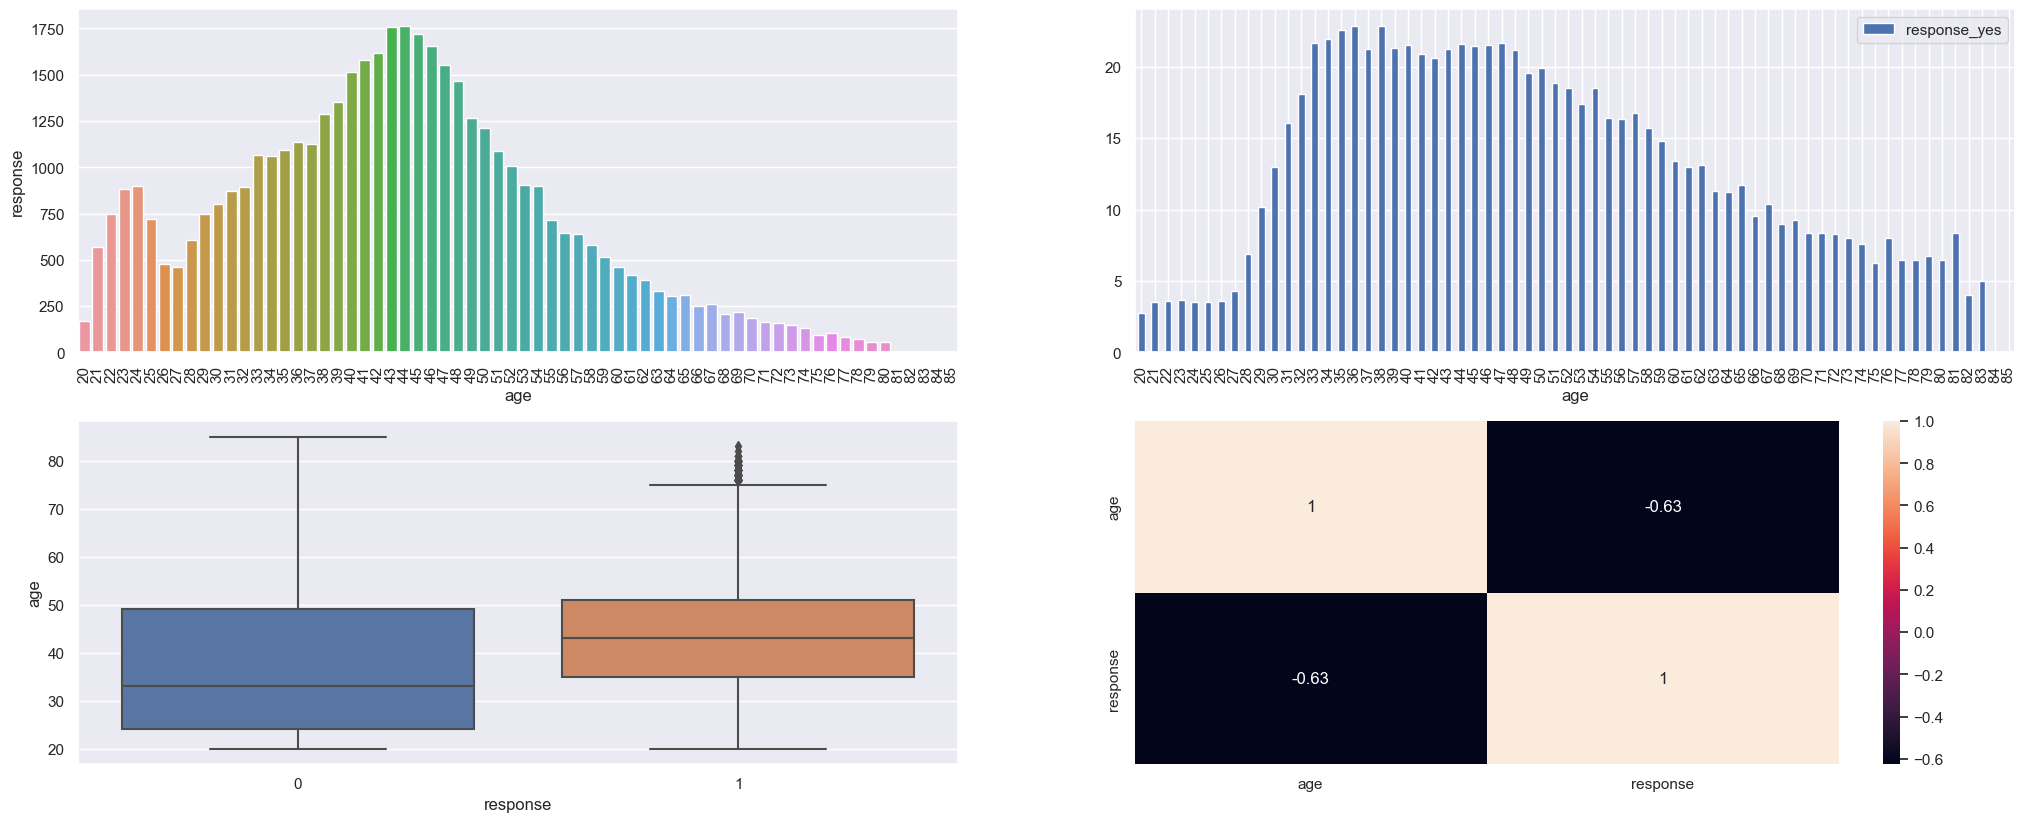

In [32]:
# ------------------ Absolute response per age --------------------------------
plt.subplot(2, 2, 1)
aux1 = df4[['age', 'response']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux1)
plt.xticks(rotation=90)

# ------------------ Frequency response per age --------------------------------
# count responses per channel
aux01 = df4[['age', 'response']].groupby('age').sum().reset_index() # count responses = 1 per channel
aux02 = df4[['age', 'response']].groupby('age').count().reset_index() # count total responses

# merge and make percentage
aux03 = pd.merge(aux01, aux02, how='inner', on='age') # merge data of responses
aux03['response_y'] = aux03.apply(lambda x: int(x['response_y'] - x['response_x']), axis=1) # adjust total response for response = 0

# transform into percentage
aux03['response_x'] = aux03.apply(lambda x: x['response_x']/(x['response_x'] + x['response_y']) * 100, axis=1)
aux03['response_y'] = aux03.apply(lambda x: 100 - x['response_x'], axis=1)

# adjust columns name
aux03.columns = ['age', 'response_yes', 'response_no']
aux03.drop(columns=['response_no'], inplace=True)

# plot
ax = plt.subplot(2, 2, 2)
aux03.plot(x = 'age', kind = 'bar', ax=ax);


# --------- Boxplot --------------------------------
plt.subplot(2, 2, 3)
sns.boxplot(x='response', y='age', data=df4)

# ---------- Correlation ----------------------------
plt.subplot(2, 2, 4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Pessoas em diferentes regiões possuem maior interesse em seguro
**VERDADEIRA** Existem regiões com maiores interesse em seguro.

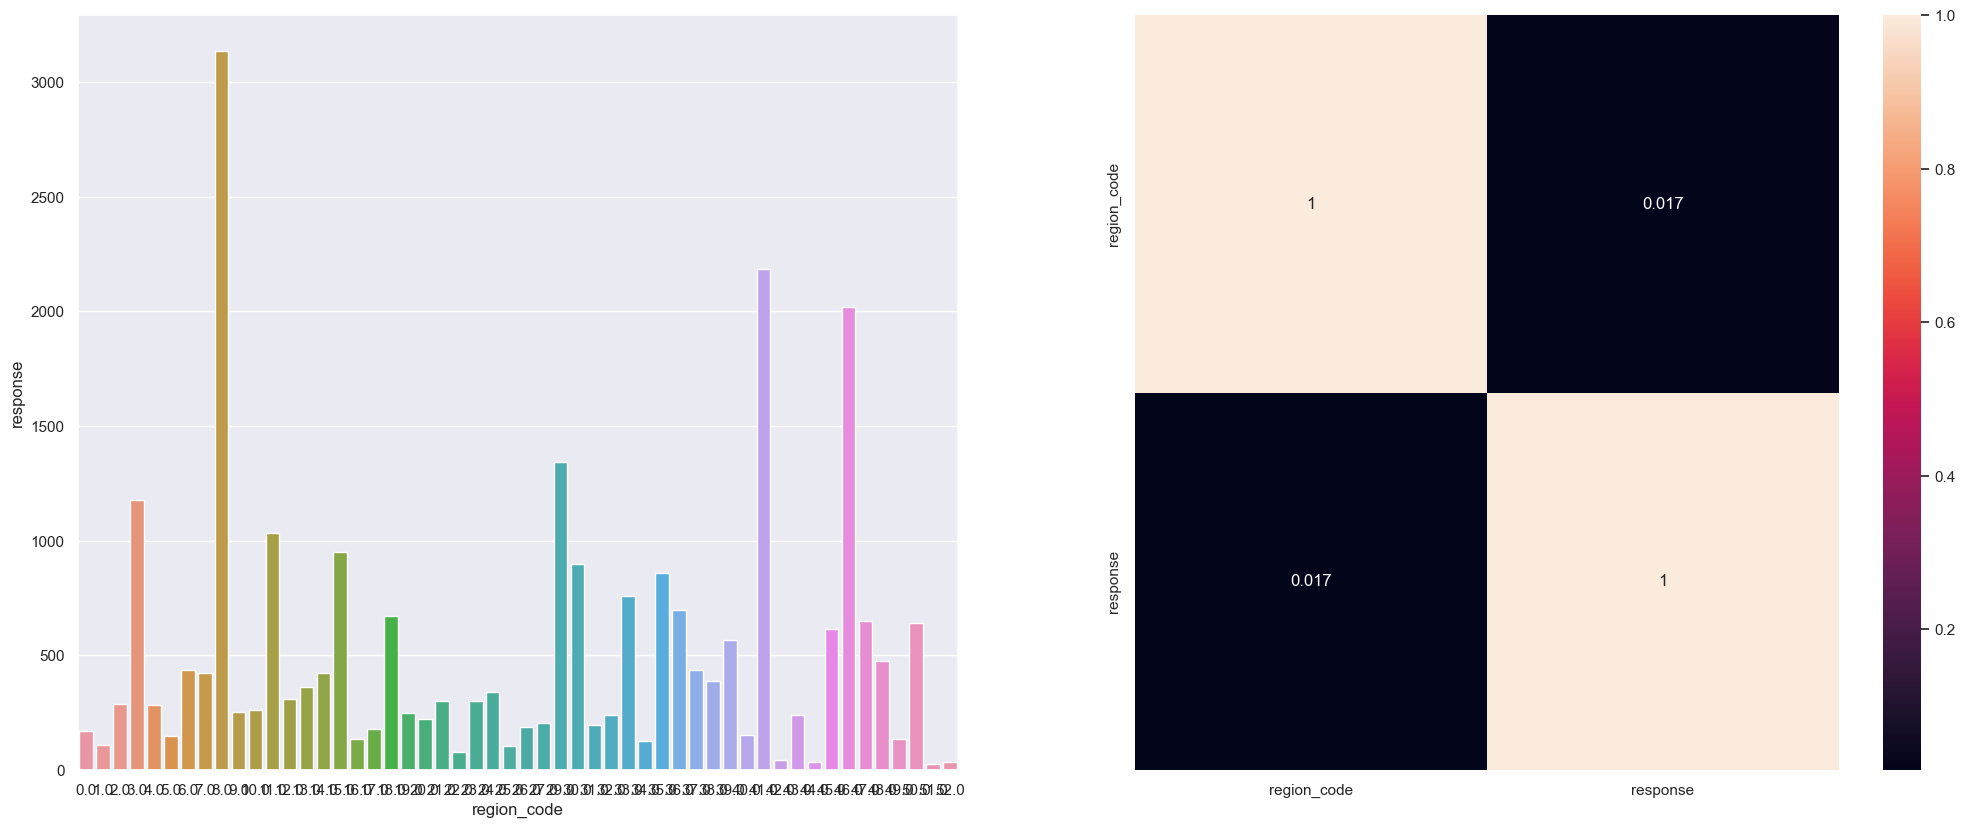

In [77]:
plt.subplot(1, 2, 1)
aux1 = df4[['region_code', 'response']].groupby('region_code').sum().reset_index()
aux2 = aux1[aux1['response'] < 4000]

sns.barplot(x='region_code', y='response', data=aux2)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H5. Pessoas com mais tempo com seguro tem maior interesse em outros seguros
**FALSA** Pessoas com maior tempo de seguro são indiferentes das com menores tempos.

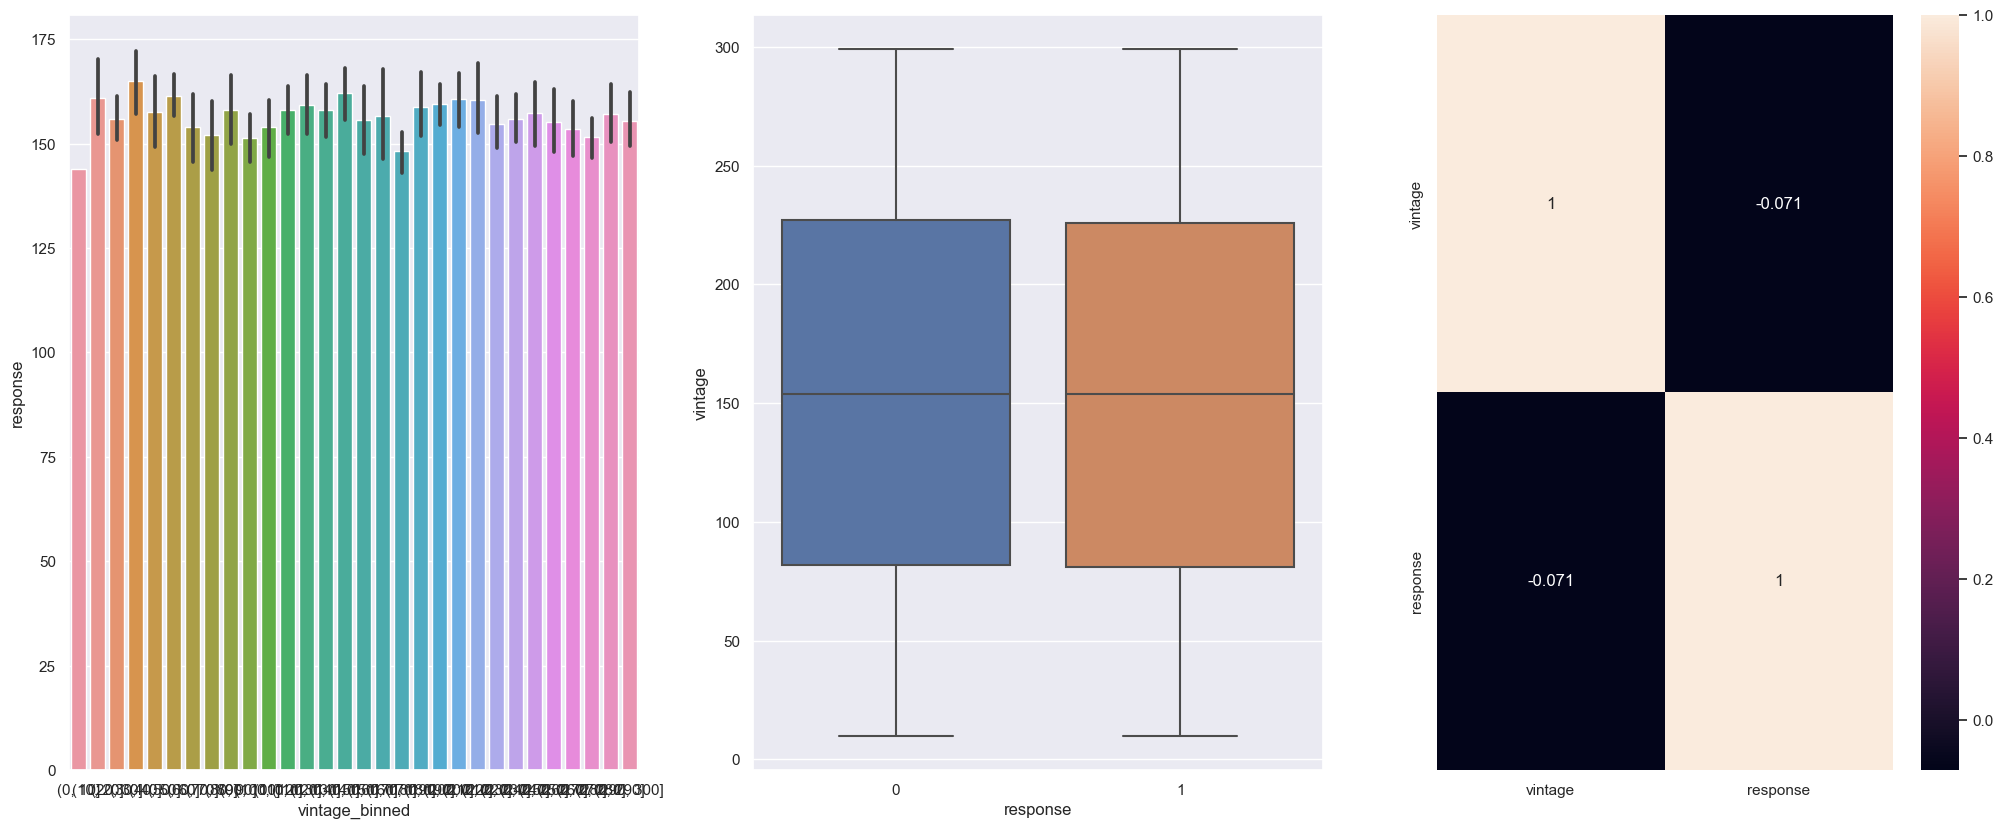

In [34]:
plt.subplot(1, 3, 1)
aux1 = df4[['vintage', 'response']].groupby('vintage').sum().sort_values('vintage').reset_index()
bins = list(np.arange(0, 310, 10))
aux1['vintage_binned'] = pd.cut(aux1['vintage'], bins = bins)

sns.barplot(x='vintage_binned', y='response', data=aux1)


plt.subplot(1, 3, 2)
sns.boxplot(x='response', y='vintage', data=df4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.1 Resumo das Hipóteses

In [35]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Verdadeira', 'Médio'],
       ['H3', 'Falsa', 'Alto'],
       ['H4', 'Verdadeira', 'Baixa'],
       ['H5', 'Falsa', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Verdadeira   Médio
H3           Falsa        Alto
H4           Verdadeira   Baixa
H5           Falsa        Baixa


## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

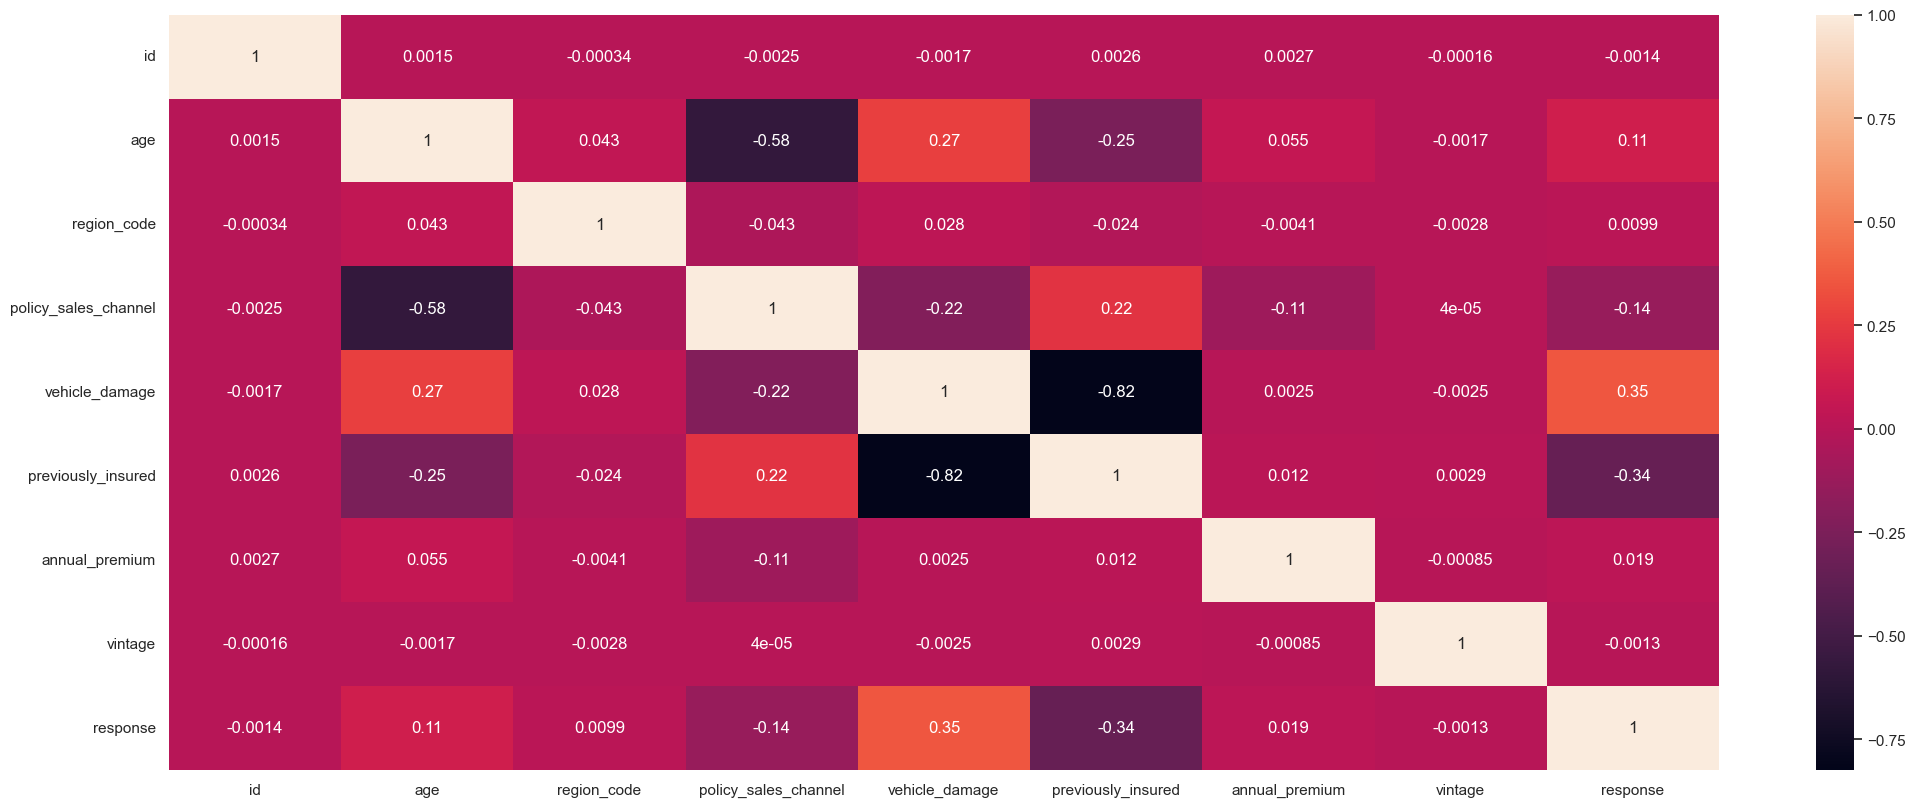

In [36]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Atributos categóricos

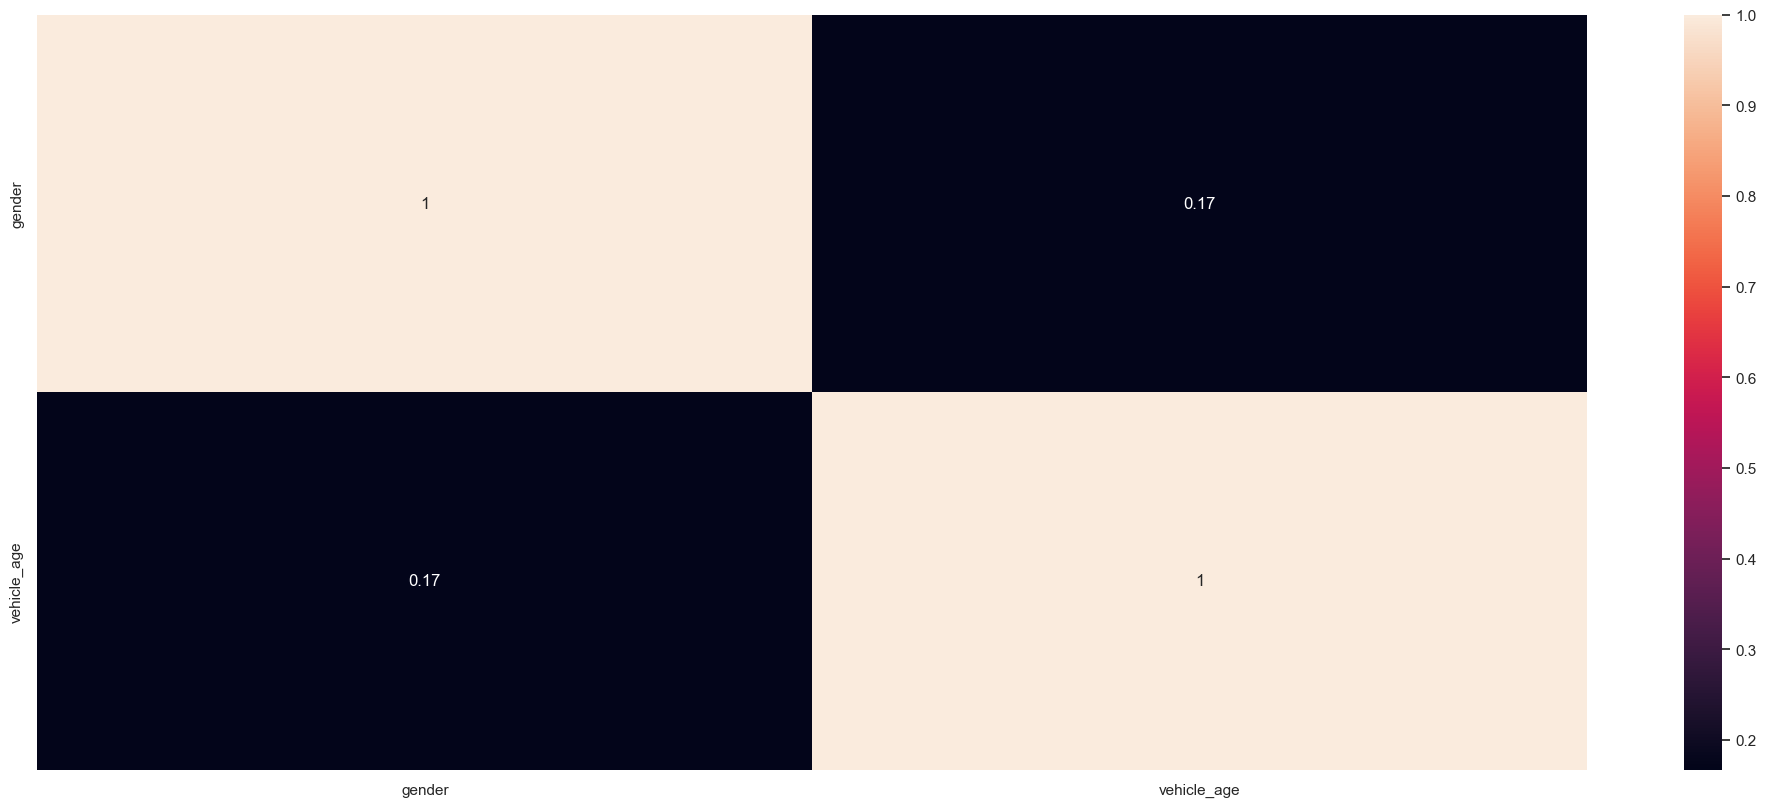

In [37]:
# only categorical data
a = df4.select_dtypes(include='object')

# Cramer V correlation
d = pycorrcat.corr_matrix(a, ['gender', 'vehicle_age'])
sns.heatmap(d, annot=True);

# 5.0 Preparação dos dados

In [38]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

# Split data into train and test
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.20, random_state=42)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [39]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

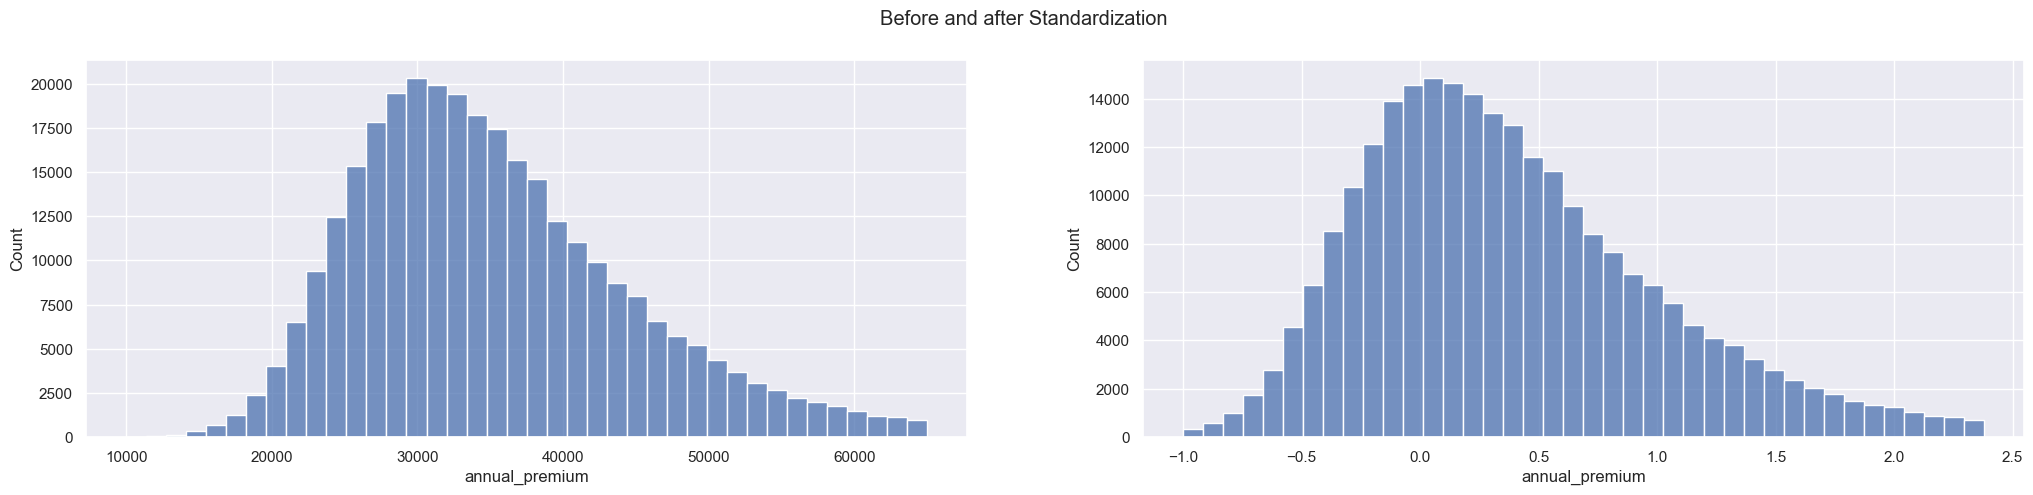

In [40]:
# Before and after

aux01 = df4[df4['annual_premium'] > 10000]
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 5))
sns.histplot(x='annual_premium', data=aux01, bins=40, ax=ax1);

aux01 = df5[df5['annual_premium'] >= -1]
sns.histplot(x='annual_premium', data=aux01, bins=40, ax=ax2);
f.suptitle('Before and after Standardization');

## 5.2 Rescaling

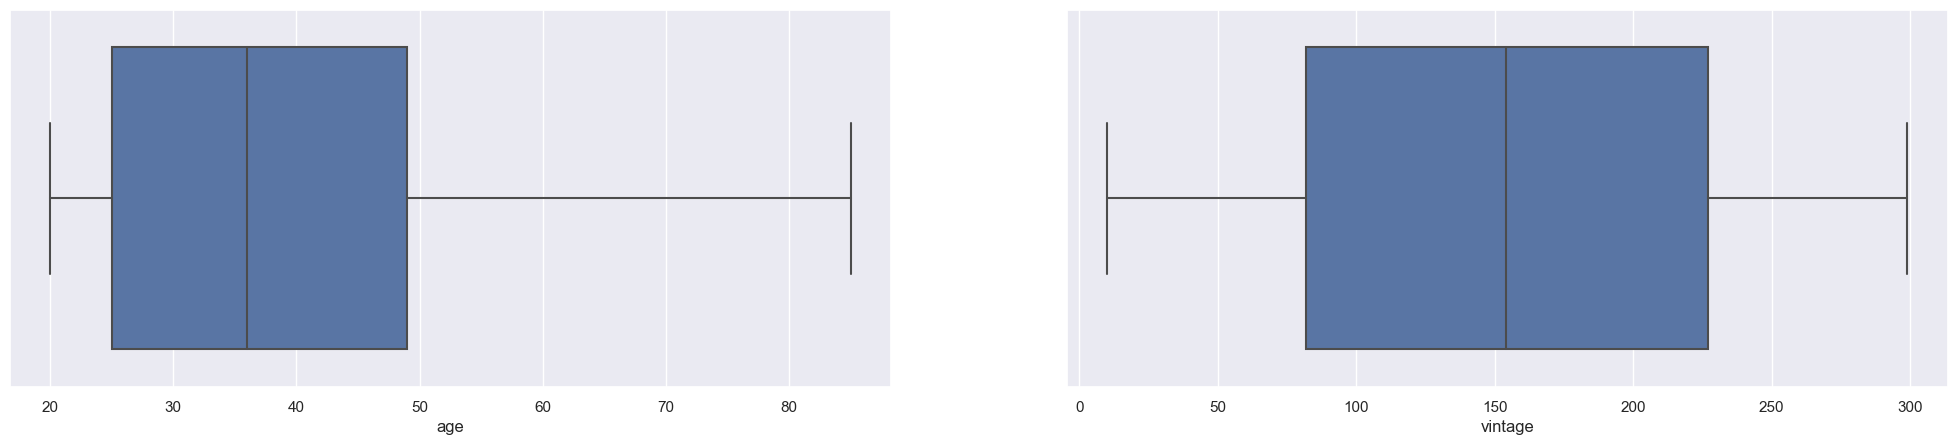

In [41]:
# Check outliers
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 5))
sns.boxplot(x='age', data=df4, ax=ax1);

sns.boxplot(x='vintage', data=df4, ax=ax2);

In [42]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

# Vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

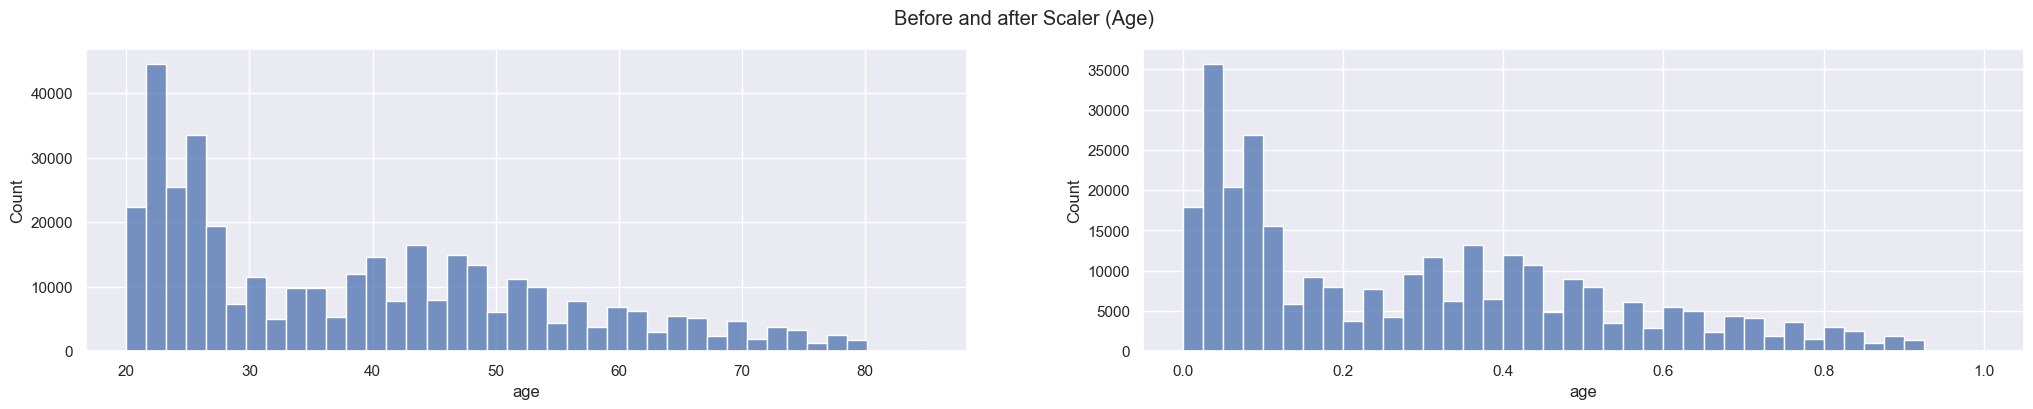

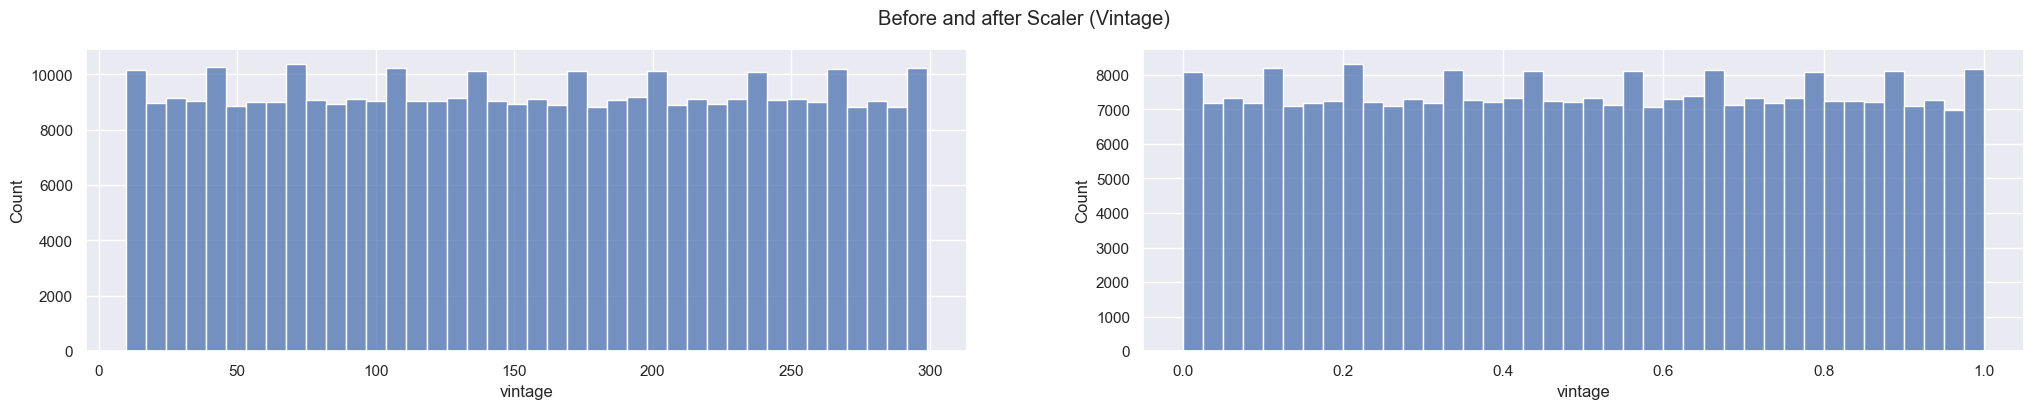

In [43]:
# -----------Before and after scaler-------------------

# plots for age
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 4))
sns.histplot(x='age', data=df4, bins=40, ax=ax1);

sns.histplot(x='age', data=df5, bins=40, ax=ax2);
f.suptitle('Before and after Scaler (Age)');

# plots for vintage
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 4))
sns.histplot(x='vintage', data=df4, bins=40, ax=ax1);

sns.histplot(x='vintage', data=df5, bins=40, ax=ax2);
f.suptitle('Before and after Scaler (Vintage)');

## 5.3 Transformação

### 5.3.1 Encoding

In [44]:
# gender - Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender.pkl', 'wb'))

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code.pkl', 'wb'))

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel.pkl', 'wb'))

## 5.4 Target variable resample

In [45]:
# Before resample
df5['response'].value_counts()

0    261489
1     36458
Name: response, dtype: int64

In [46]:
x_train_res, y_train_res = SMOTETomek(random_state=42).fit_resample(df5.drop(columns=['response'], axis=1), df5['response'])

# After resample
y_train_res.value_counts()

0    233113
1    233113
Name: response, dtype: int64

## 5.5 Test data preparation

In [47]:
# annual_premium
x_test.loc[:, 'annual_premium'] = ss.transform(x_test[['annual_premium']].values)

# Age
x_test.loc[:, 'age'] = mms_age.transform(x_test[['age']].values)

# Vintage
x_test.loc[:, 'vintage'] = mms_vintage.transform(x_test[['vintage']].values)

# gender - Target Encoding
x_test.loc[:, 'gender'] = x_test.loc[:, 'gender'].map(target_encode_gender)

# region_code - Target Encoding
x_test.loc[:, 'region_code'] = x_test.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding
x_test = pd.get_dummies(x_test, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
x_test.loc[:, 'policy_sales_channel'] = x_test.loc[:, 'policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_test = x_test.fillna(0)


# 6.0 Feature Selection

## 6.1 feature selection per importance

In [48]:
# model definition
#forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
#x_train_f = x_train_res.drop(['id'], axis=1)
#y_train_f = y_train_res.values
#forest.fit(x_train_f, y_train_f)

# saving model
#pickle.dump(forest, open('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/models/extra_tree_selector.pkl', 'wb'))

# loading model selector
#file = open('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/models/extra_tree_selector.pkl','rb')
#forest = pickle.load(file)
#file.close()

In [49]:
# Collect features from model selector
#importances = forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
#indices = np.argsort(importances)[::-1]

# Organize and print ranking per features
#print('Feature ranking:')
#df = pd.DataFrame()
#for i, j in zip(x_train_f, forest.feature_importances_):
#    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
#    df = pd.concat([df, aux], axis=0)

#print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
#plt.figure()
#plt.title('Feature importances')
#plt.bar(range(x_train_f.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
#plt.xticks(range(x_train_f.shape[1]), indices)
#plt.xlim([-1, x_train_f.shape[1]])
#plt.show()

## 6.2 Boruta selection

In [50]:
# training and test dataset for Boruta
#x_train_f = x_train_f.values
#y_train_f = y_train_f.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_f, y_train_f)

#cols_selected = boruta.support_.tolist()

# best features
#cols_selected_boruta = x_train_f.iloc[:, cols_selected]

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_f.columns, cols_selected_boruta.columns))


In [51]:
#cols_not_selected_boruta

In [52]:
#cols_selected_boruta.columns

# 7.0 Machine Learning Modeling

In [53]:
# select features from Metrics
cols_selected = ['id', 'vintage', 'annual_premium', 'age', 'region_code',
                'vehicle_damage', 'policy_sales_channel', 'previously_insured']


# Dataframe for metrics
x_testm = x_test[cols_selected].copy()
y_testm = y_test.copy()

# select features from ML
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
                'vehicle_damage', 'policy_sales_channel', 'previously_insured']

# Dataframe for ML
x_train_res = x_train_res[cols_selected]
x_test = x_test[cols_selected]

## 7.1 K-Nearest Neighbors

In [ ]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train_res, y_train_res)

# model prediction - Generalization
yhat_knn = knn_model.predict_proba(x_test)
yhatp_knn = knn_model.predict( x_test )


# ---------- Metrics ------------------
# Accuracy score
ba_knn = balanced_accuracy_score(y_test, yhatp_knn)

print(f'Accuracy from balanced score is: {ba_knn:.3f}')

Accuracy from balanced score is: 0.720


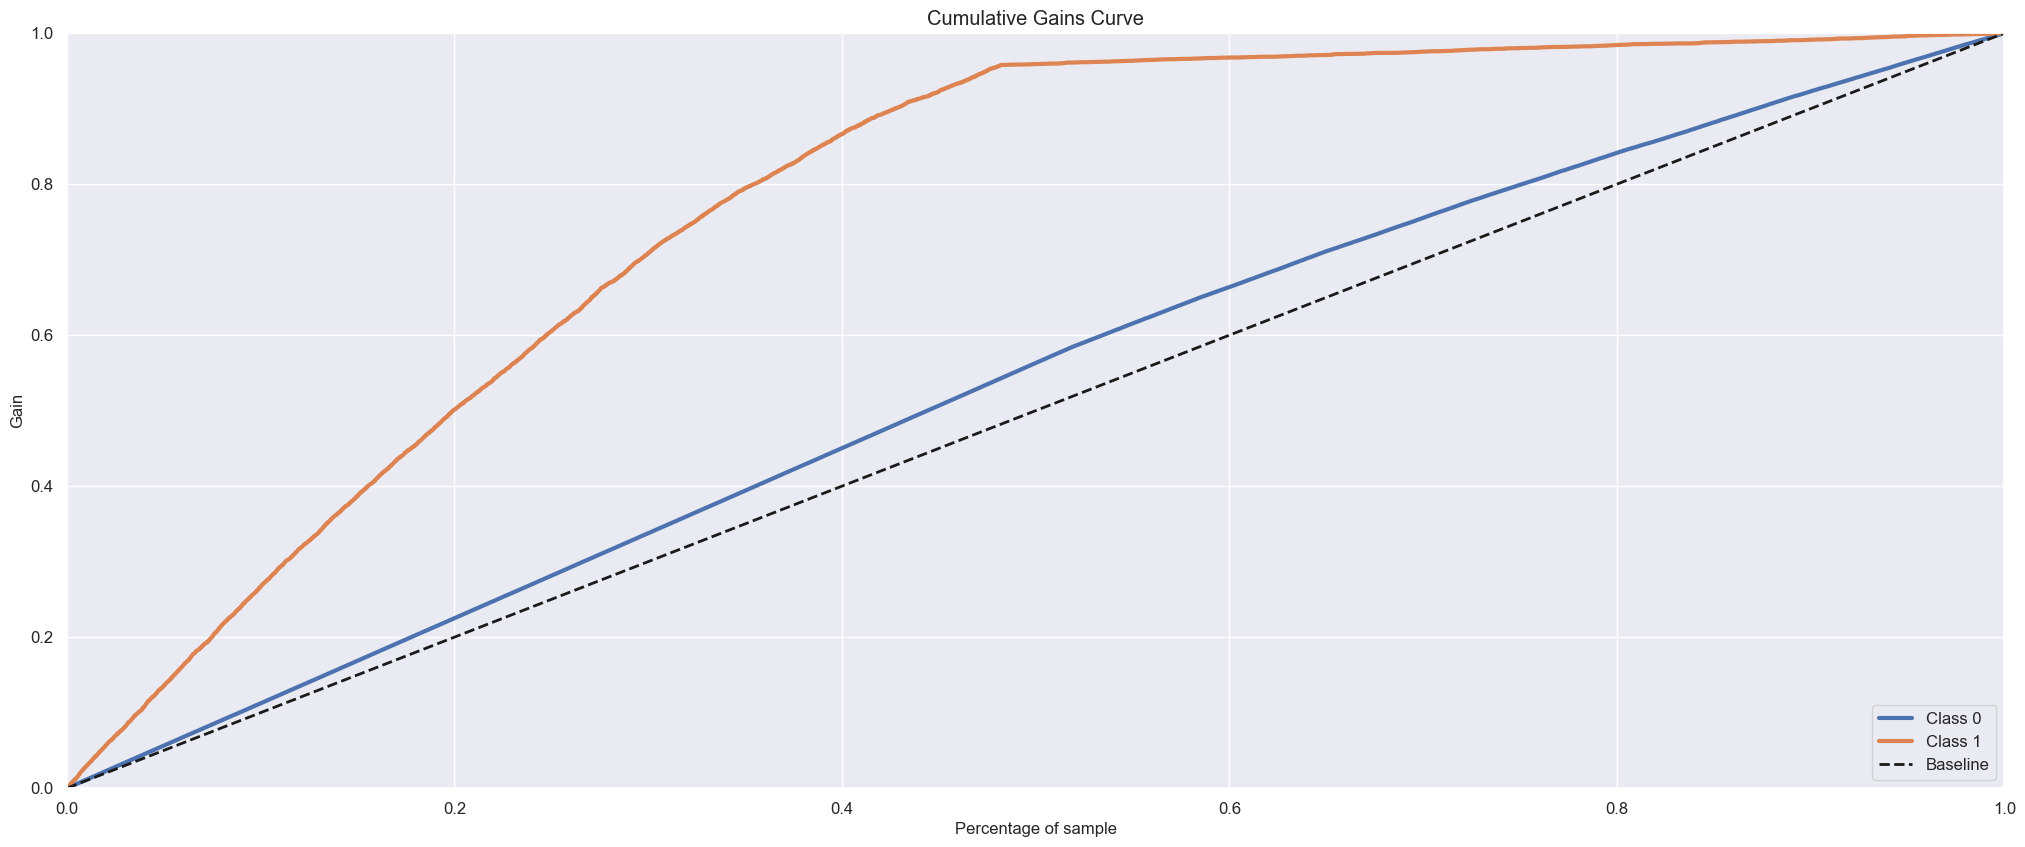

In [ ]:
# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn);

### 7.1.1 K-Nearest Neighbors - Cross-Validation

In [ ]:
# making cross validation
#cv_knn = runCrossValidation(knn_model, x_train_res, y_train_res, n_splits=10, top_k = 20000, verbose=True)

# saving results
#pickle.dump(cv_knn, open('../data/processed/cv_knn.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_knn.pkl','rb')
cv_knn = pickle.load(file)
file.close()

cv_knn

,mean,std
precision_at_k,0.872,0.011
recall_at_k,0.749,0.010
accuracy_score,0.847,0.002


## 7.2 Logistic Regression

In [ ]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train_res, y_train_res )

# model prediction
yhat_lr = lr_model.predict_proba( x_test )
yhatp_lr = lr_model.predict( x_test )


# ---------- Metrics ------------------
# Accuracy score
ba_lr = balanced_accuracy_score(y_test, yhatp_lr)

print(f'Accuracy from balanced score is: {ba_lr:.3f}')

Accuracy from balanced score is: 0.783


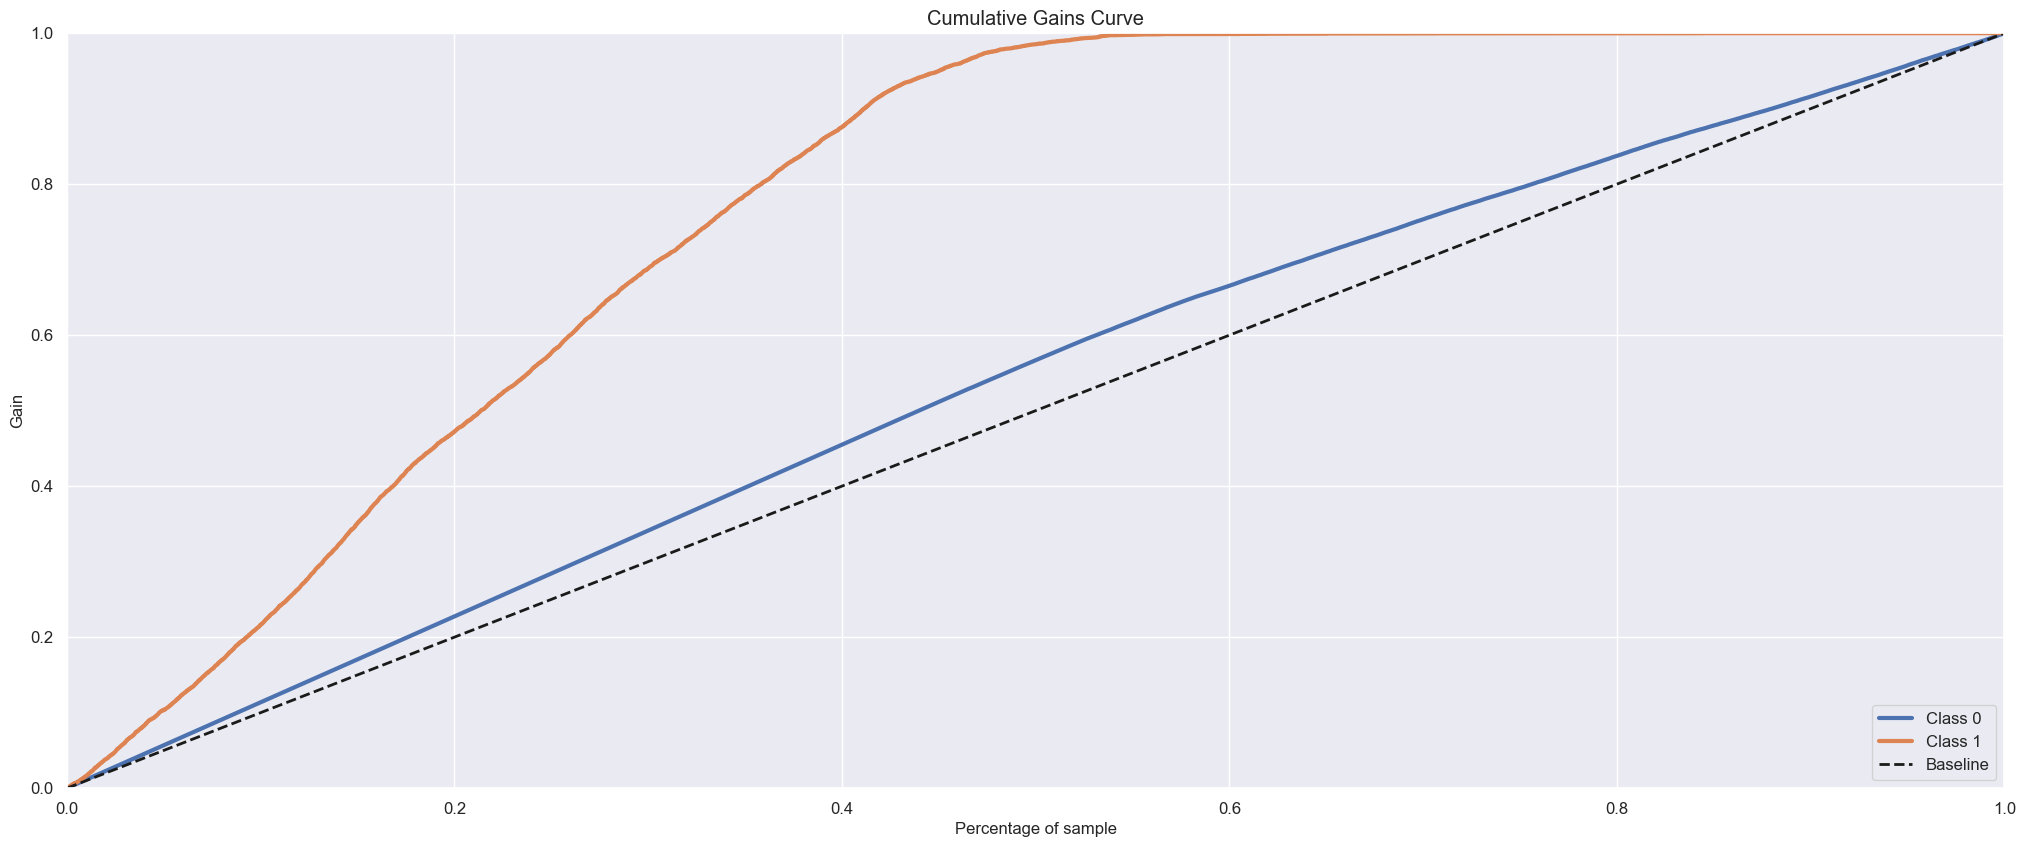

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_lr );

### 7.2.1 Logistic Regression - Cross-Validation

In [ ]:
# making cross validation
#cv_lr = runCrossValidation(lr_model, x_train_res, y_train_res, n_splits=10, top_k = 20000, verbose=True)

# saving results
#pickle.dump(cv_lr, open('../data/processed/cv_lr.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_lr.pkl','rb')
cv_lr = pickle.load(file)
file.close()

cv_lr

,mean,std
precision_at_k,0.775,0.001
recall_at_k,0.665,0.001
accuracy_score,0.796,0.001


## 7.3 Extra Trees

In [ ]:
# model definition
#et_model = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# model training
#et_model.fit( x_train_res, y_train_res )

# model prediction
#yhat_et = et_model.predict_proba( x_test )
#yhatp_et = et_model.predict( x_test )

# ---------- Metrics ------------------
# Accuracy score
#ba_et = balanced_accuracy_score(y_test, yhatp_et)

# Accumulative gain plot
#plot_et = skplt.metrics.plot_cumulative_gain( y_test, yhat_et);

# -------------- Saving and Loading Metrics -------------------
# saving results
#pickle.dump(ba_et, open('../data/interim/ba_et.pkl', 'wb'))
#pickle.dump(plot_et, open('../data/interim/plot_et.pkl', 'wb'))

# loading results
file = open('../data/interim/ba_et.pkl','rb')
ba_et = pickle.load(file)
file.close()

# show metrics
print(f'Accuracy from balanced score is: {ba_et:.3f}')

Accuracy from balanced score is: 0.549


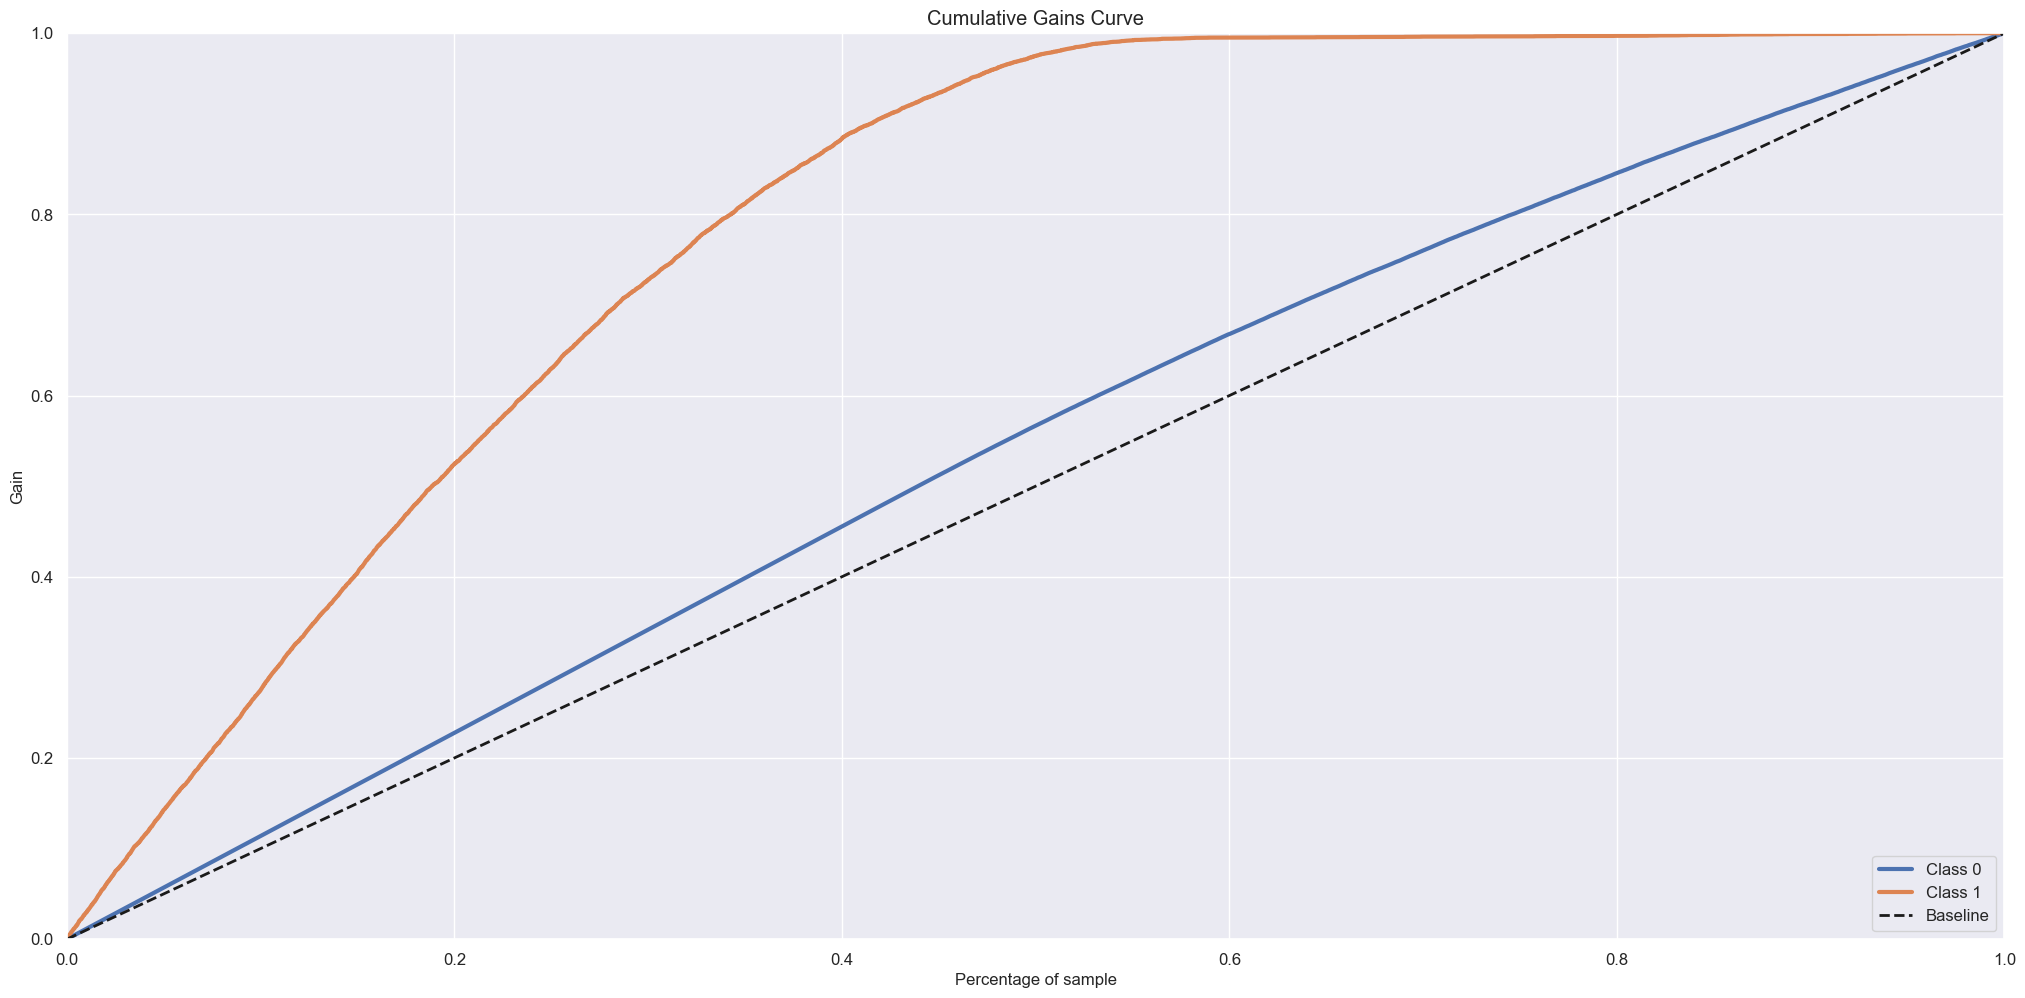

In [ ]:
# loading results
file = open('../data/interim/plot_et.pkl','rb')
plot_et = pickle.load(file)
file.close()

# Accumulative Gain
plot_et;

### 7.3.1 Extra Trees - Cross-Validation

In [ ]:
# making cross validation
#cv_et = runCrossValidation(et_model, x_train_res, y_train_res, n_splits=10, top_k = 20000, verbose=True)

# saving results
#pickle.dump(cv_et, open('../data/processed/cv_et.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_et.pkl','rb')
cv_et = pickle.load(file)
file.close()

cv_et

,mean,std
precision_at_k,0.965,0.001
recall_at_k,0.829,0.001
accuracy_score,0.904,0.001


## 7.4 XGBoost

In [ ]:
# model definition
#xgb_model = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model training
#xgb_model.fit( x_train_res, y_train_res )

# model prediction
#yhat_xgb = xgb_model.predict_proba( x_test )
#yhatp_xgb = xgb_model.predict( x_test )

# ---------- Metrics ------------------
# Accuracy score
#ba_xgb = balanced_accuracy_score(y_test, yhatp_xgb)

# Accumulative gain plot
#plot_xbg = skplt.metrics.plot_cumulative_gain( y_test, yhat_xgb );


# -------------- Saving and Loading model -------------------
# saving results
#pickle.dump(ba_xgb, open('../data/interim/ba_xgb.pkl', 'wb'))
#pickle.dump(plot_xbg, open('../data/interim/plot_xbg.pkl', 'wb'))

# loading results
file = open('../data/interim/ba_xgb.pkl','rb')
ba_xgb = pickle.load(file)
file.close()

# show metrics
print(f'Accuracy from balanced score is: {ba_xgb:.3f}')

Accuracy from balanced score is: 0.533


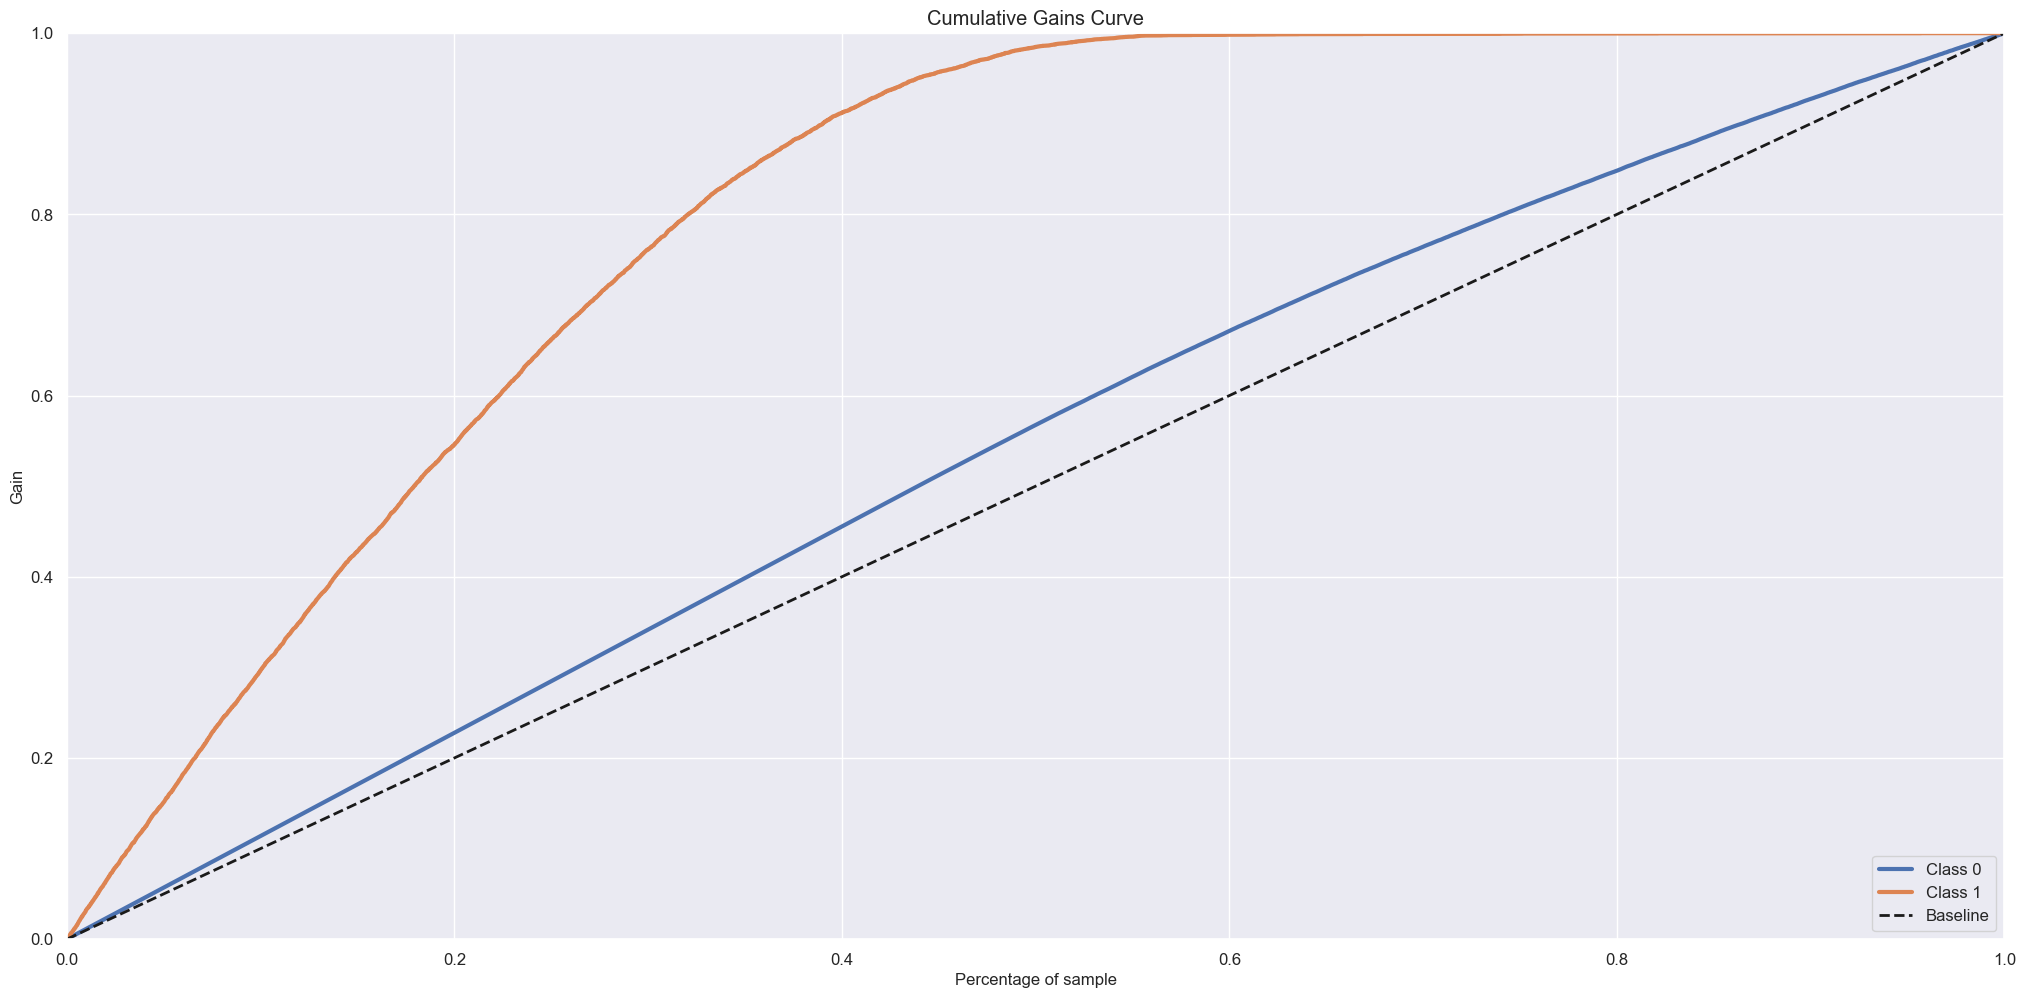

In [ ]:
# loading results
file = open('../data/interim/plot_xbg.pkl','rb')
plot_xbg = pickle.load(file)
file.close()

# ---------- Metrics ------------------
# Accumulative Gain
plot_xbg;

### 7.4.1 XGBoost - Cross-Validation

In [ ]:
#xgb_model = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# making cross validation
#cv_xgb = runCrossValidation(xgb_model, x_train_res, y_train_res, n_splits=10, top_k = 20000, verbose=True)

# saving results
#pickle.dump(cv_xgb, open('../data/processed/cv_xgb.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_xgb.pkl','rb')
cv_xgb = pickle.load(file)
file.close()

cv_xgb

,mean,std
precision_at_k,0.995,0.001
recall_at_k,0.854,0.001
accuracy_score,0.921,0.001


## 7.5 LGBM

In [ ]:
# model definition
lgbm_model = LGBMClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model training
lgbm_model.fit( x_train_res, y_train_res )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_test )
yhatp_lgbm = lgbm_model.predict( x_test )


# ---------- Metrics ------------------
# Accuracy score
ba_lgbm = balanced_accuracy_score(y_test, yhatp_lgbm)

print(f'Accuracy from balanced score is: {ba_lgbm:.3f}')

Accuracy from balanced score is: 0.552


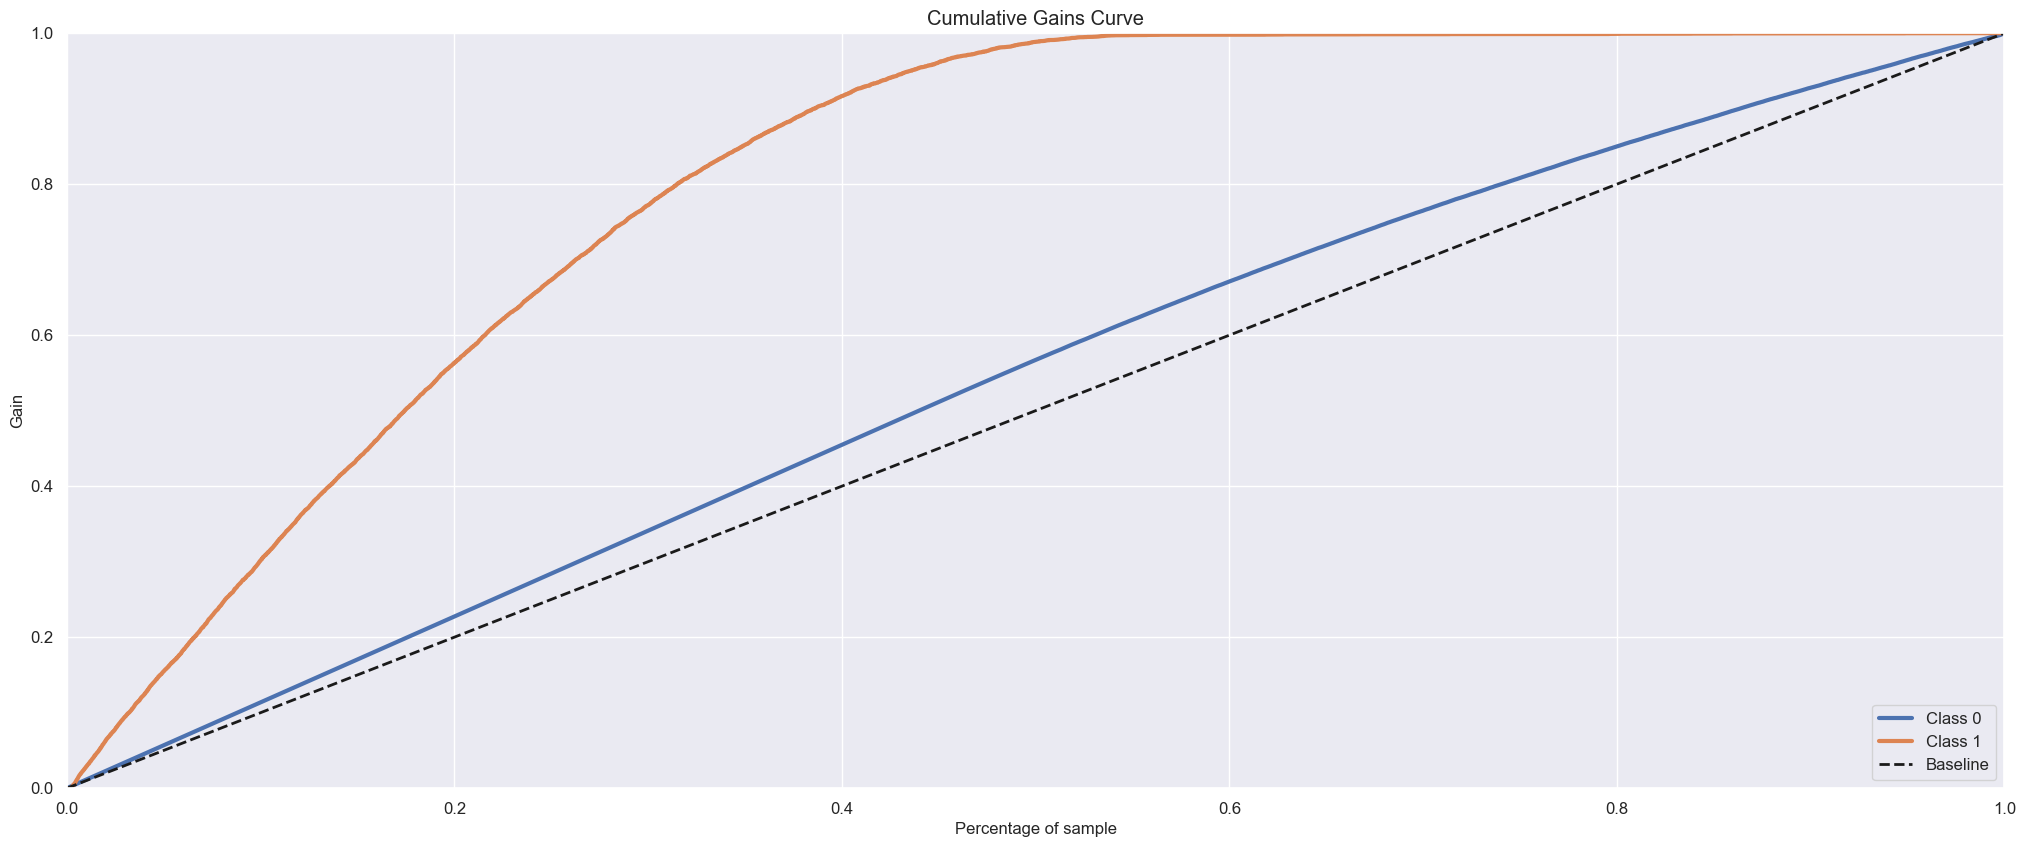

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_lgbm );

### 7.5.1 LGBM - Cross-Validation

In [ ]:
# making cross validation
#cv_lgbm = runCrossValidation(lgbm_model, x_train_res, y_train_res, n_splits=10, top_k=20000, verbose=True)

# saving results
#pickle.dump(cv_lgbm, open('../data/processed/cv_lgbm.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_lgbm.pkl','rb')
cv_lgbm = pickle.load(file)
file.close()

cv_lgbm

,mean,std
precision_at_k,0.991,0.001
recall_at_k,0.851,0.001
accuracy_score,0.921,0.001


## 7.6 Balanced Random Forest Classifier

In [ ]:
# model definition
#brf_model = ien.BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42, sampling_strategy=0.14)

# model training - with unbalanced data
#brf_model.fit( x_train, y_train )

# model prediction
#yhat_brf = brf_model.predict_proba( x_test )
#yhatp_brf = brf_model.predict( x_test )

# ---------- Metrics ------------------
# Accuracy score
#ba_brf = balanced_accuracy_score(y_test, yhatp_brf)

# Accumulative gain plot
#plot_brf = skplt.metrics.plot_cumulative_gain( y_test, yhat_brf )


# -------------- Saving and Loading model -------------------
# saving results
#pickle.dump(ba_brf, open('../data/interim/ba_brf.pkl', 'wb'))
#pickle.dump(plot_brf, open('../data/interim/plot_brf.pkl', 'wb'))

# loading results
file = open('../data/interim/ba_brf.pkl','rb')
ba_brf = pickle.load(file)
file.close()

# show metrics
print(f'Accuracy from balanced score is: {ba_brf:.3f}')

Accuracy from balanced score is: 0.546


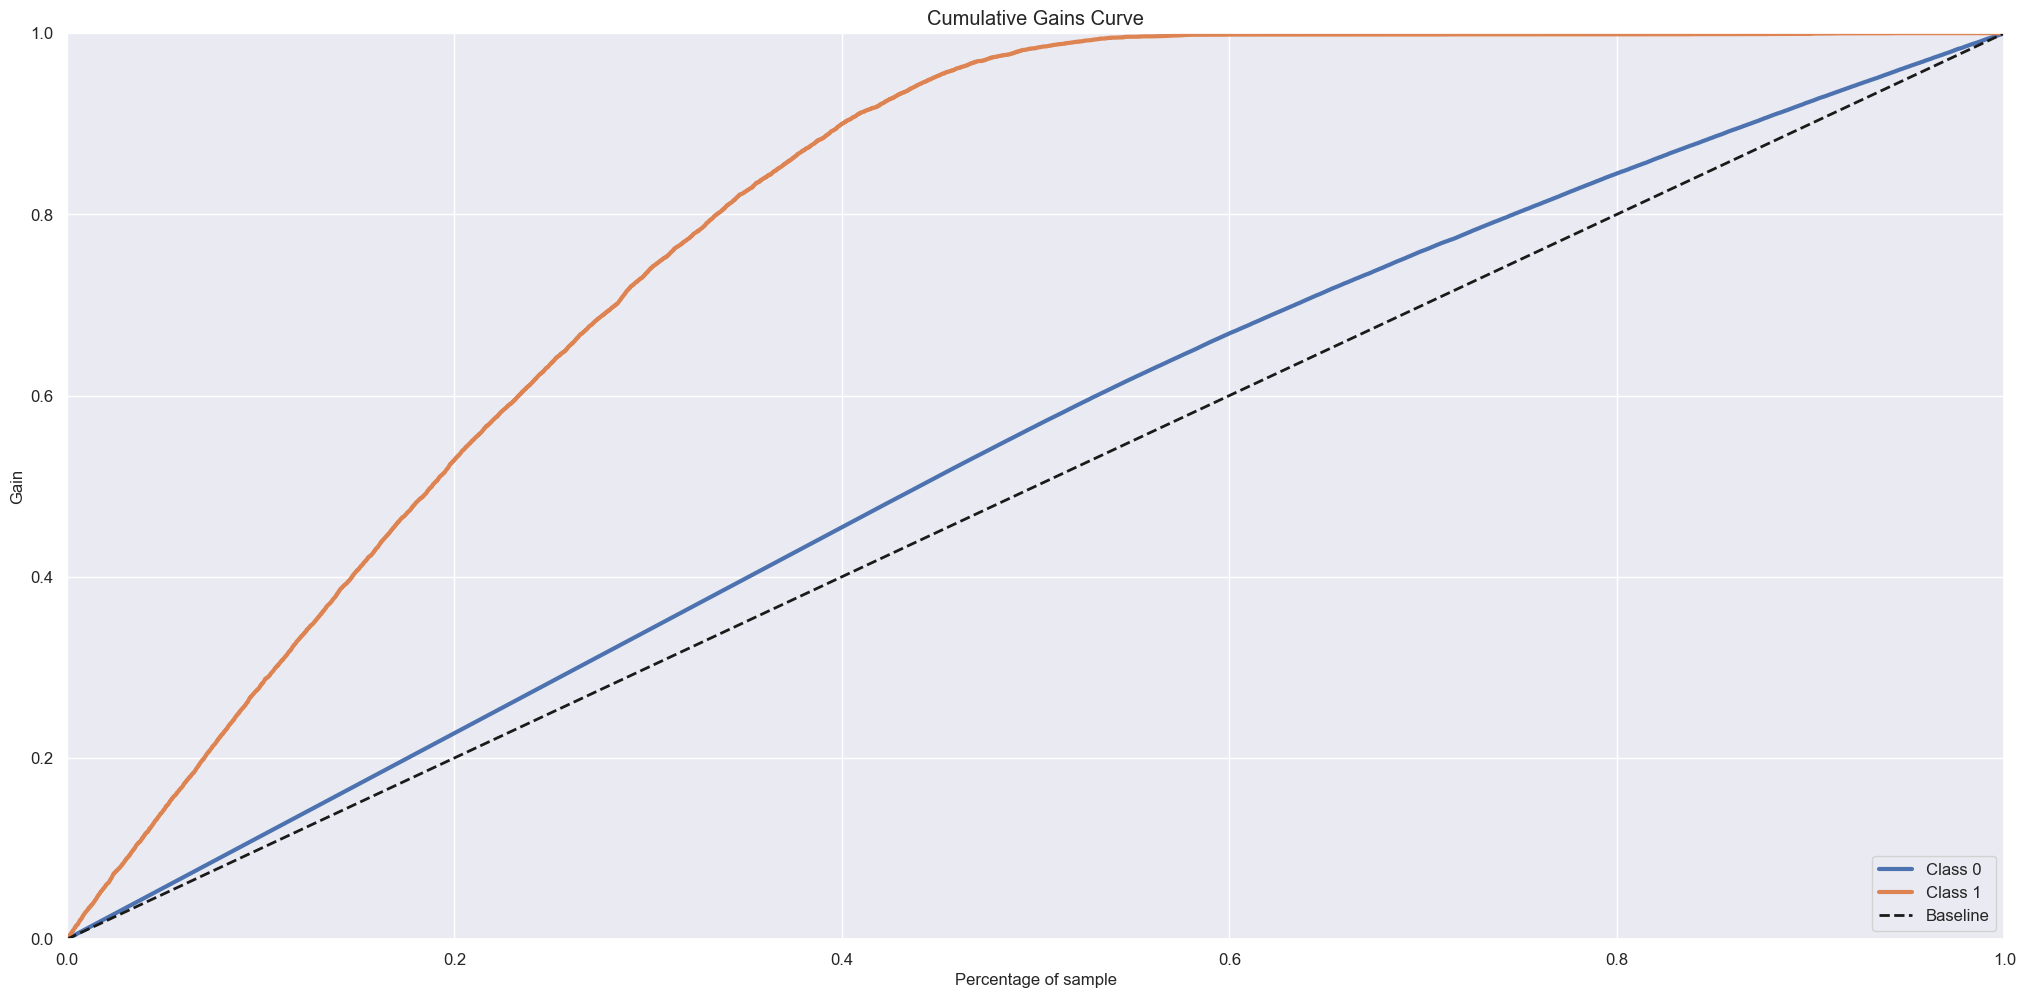

In [ ]:
# loading results
file = open('../data/interim/plot_brf.pkl','rb')
table_brf = pickle.load(file)
file.close()

# ---------- Metrics ------------------
# Accumulative Gain
table_brf;

### 7.6.1 Balanced Random Forest - Cross-Validation

In [ ]:
# making cross validation
#cv_brf = runCrossValidation(brf_model, x_train, x_test, y_train, y_test, n_splits=10, top_k=20000, verbose=True)

# saving results
#pickle.dump(cv_brf, open('../data/processed/cv_brf.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_brf.pkl','rb')
cv_brf = pickle.load(file)
file.close()

cv_brf

,mean,std
precision_at_k,0.973,0.002
recall_at_k,0.803,0.001


## 7.7 Compare Model's Performance

### 7.7.1 Real Performance - Cross Validation

In [ ]:
#final_cv = pd.DataFrame()
#model_list = {'KNN_model' : cv_knn, 'Logistic_Regression' : cv_lr, 'Extra_Trees_Classifier' : cv_et, 'XGBoost' : cv_xgb, 'LGBM' : cv_lgbm, 'Balanced_RF' : cv_brf}

#for n, m in model_list.items():
#    m[n] = m.apply(lambda x : (str(x['mean']))[:5] + '+/-' + (str(x['std']))[:5], axis=1)
#    m = m[[n]].T
#    m.reset_index(inplace=True)
#    if len(m.columns) > 3:
#        m.drop(columns=['accuracy_score'], inplace=True)
#    m.columns = ['model_name', 'precision_at_k', 'recall_at_k']

#    final_cv = pd.concat([final_cv, m])

#final_cv.sort_values('precision_at_k', ascending=False, inplace=True)

# saving results
#pickle.dump(final_cv, open('../data/processed/ml_result_cv.pkl', 'wb'))

# loading results
file = open('../data/processed/ml_result_cv.pkl','rb')
ml_result_cv = pickle.load(file)
file.close()
ml_result_cv

,model_name,precision_at_k,recall_at_k
0,XGBoost,0.994+/-0.001,0.854+/-0.001
0,LGBM,0.990+/-0.001,0.850+/-0.001
0,Balanced_RF,0.972+/-0.001,0.802+/-0.001
0,Extra_Trees_Classifier,0.964+/-0.001,0.828+/-0.001
0,KNN_model,0.871+/-0.011,0.748+/-0.009
0,Logistic_Regression,0.774+/-0.001,0.665+/-0.001


# 8.0 Hyper Parameter Fine Tunning

## 8.1 Bayesian Search

In [ ]:
""" # model definition
lgbm_model = LGBMClassifier(n_jobs=-1, random_state=42, subsample_freq=1)


# Search space for hyper parameters
search_space = [Integer( 100, 1500, name = 'n_estimators'), 
                Integer(1, 20, name = 'max_depth'), 
                Real(0.001, 0.1, 'log-uniform', name = 'learning_rate'),
                Integer(2, 128, name = 'num_leaves'),
                Integer(1, 100, name = 'min_child_samples'),
                Real(0.05, 1.0, name = 'subsample'),
                Real(0.15, 1.0, name = 'colsample_bytree')]



# applying cross-validation into tunning
@use_named_args(search_space)
def model_eval( **params ):
	
    lgbm_model.set_params(**params)
    print(lgbm_model)
    ft_result = runCrossValidation(lgbm_model, x_train_res, y_train_res, n_splits=10, top_k=20000, verbose=False)
    return -ft_result['mean'][0]


# create checkpoints
checkpoint_callback = CheckpointSaver('../models/lgbm_ft.pkl')

# return results and run bayesian optimize
result = gp_minimize( model_eval, search_space, n_calls = 50, 
                      n_initial_points = 10, verbose=True, n_jobs=-1, 
                      random_state= 42, callback=[checkpoint_callback])
result """

" # model definition\nlgbm_model = LGBMClassifier(n_jobs=-1, random_state=42, subsample_freq=1)\n\n\n# Search space for hyper parameters\nsearch_space = [Integer( 100, 1500, name = 'n_estimators'), \n                Integer(1, 20, name = 'max_depth'), \n                Real(0.001, 0.1, 'log-uniform', name = 'learning_rate'),\n                Integer(2, 128, name = 'num_leaves'),\n                Integer(1, 100, name = 'min_child_samples'),\n                Real(0.05, 1.0, name = 'subsample'),\n                Real(0.15, 1.0, name = 'colsample_bytree')]\n\n\n\n# applying cross-validation into tunning\n@use_named_args(search_space)\ndef model_eval( **params ):\n\t\n    lgbm_model.set_params(**params)\n    print(lgbm_model)\n    ft_result = runCrossValidation(lgbm_model, x_train_res, y_train_res, n_splits=10, top_k=20000, verbose=False)\n    return -ft_result['mean'][0]\n\n\n# create checkpoints\ncheckpoint_callback = CheckpointSaver('../models/lgbm_ft.pkl')\n\n# return results and run ba

In [ ]:
# check best parameters

#result.x

## 8.2 Final Model

In [55]:
params = {'n_estimators' : 844,
            'max_depth' : 16,
            'learning_rate' : 0.026258,
            'num_leaves' : 128,
            'min_child_samples' : 100,
            'subsample' : 1.0,
            'colsample_bytree' : 0.372328}

# LGBM Model
lgbm_model = LGBMClassifier(n_jobs=-1, random_state=42, subsample_freq=1)
lgbm_model.set_params(**params)
lgbm_model.fit(x_train_res, y_train_res)

# results of train dataset
y_pred = lgbm_model.predict_proba( x_test )

In [80]:
# ------- check result--------

df8 = x_testm.copy()
df8['response'] = y_testm.copy()

# propensity score
df8['score'] = y_pred[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision and recall at 20.000 k
metrics, data = precision_recall_at_k(df8)

# organize results
metrics = pd.DataFrame(metrics)
metrics = metrics.T
metrics['model_name'] = 'LGBM_Model'
metrics.columns = ['precision_at_K', 'recall_at_K', 'model_name']
metrics = metrics[['model_name', 'precision_at_K', 'recall_at_K']]
metrics


,model_name,precision_at_K,recall_at_K
0,LGBM_Model,0.322,0.715


In [ ]:
ft_result = runCrossValidation(lgbm_model, x_train_res, y_train_res, n_splits=10, top_k=20000, verbose=False)
ft_result

,mean,std
precision_at_k,0.993,0.002
recall_at_k,0.852,0.001
accuracy_score,0.923,0.002


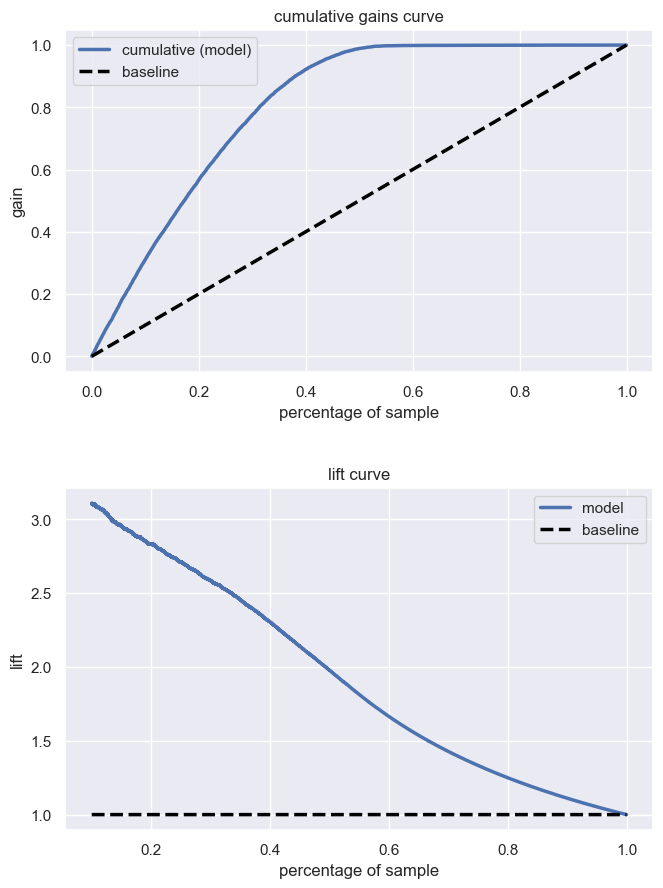

In [ ]:
data = gain_lift_curve(y_pred, y_test)

# 9.0 Tradução e interpretação do erro

In [81]:
df9 = df8.copy()

## 9.1 Bussiness Performance

In [84]:
print (f"We have {df9.shape[0]} new customers, of which {round(df9.loc[df9['response'] == 1].shape[0])} are interested in vehicle insurance. ({round(df9.loc[df9['response'] == 1].shape[0] / df9.shape[0] *100 ,2) }% of total new customers)")

print (f"The average ticket for an annual car insurance from 2021 is: Rs 4.273,83.")
print (f"\nAssuming that all customers interested in vehicle insurance will sign the contract, and that the average value of vehicle insurance will be \
\nthe same as the average of 2021 is, we can estimate as invoicing scenarios:")

We have 74487 new customers, of which 9010 are interested in vehicle insurance. (12.1% of total new customers)
The average ticket for an annual car insurance from 2021 is: Rs 4.273,83.

Assuming that all customers interested in vehicle insurance will sign the contract, and that the average value of vehicle insurance will be 
the same as the average of 2021 is, we can estimate as invoicing scenarios:


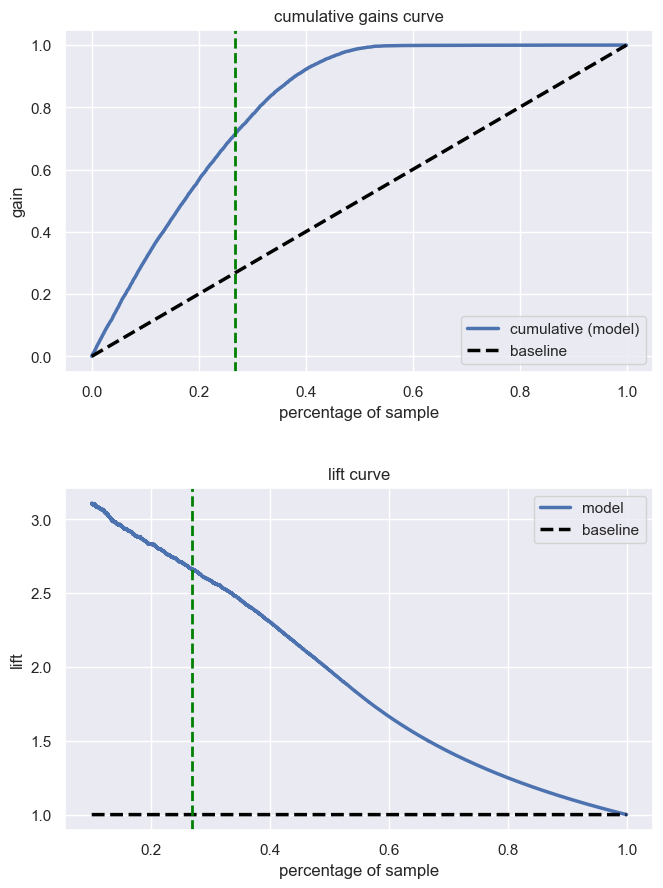


_______________________________ SCENARIO WITH 20000 PHONE CALLS _____________________________________________________________________________
By random list:
 - The sales team contacts 27% of those interested in car insurance: 2419 customers (see Gain: intersection black x green line).
  ==>  Estimated revenue: 2419 * 4.273,83 = Rs 10.34M per year.

By sorted list (model):
 - The sales team contacts 72% of those interested in car insurance: 6444 customers (see Gain: intersection blue x green line).
  ==> Estimated revenue: 6444 * 4.273,83 = Rs 27.54M per year.

RESULT: The model is 2.66 times better than the random list (see Lift: intersection blue x green line). 
So the estimated revenue is 2.66 times higher than the random list: Rs 17.2M.


In [86]:
# Making metrics for best 20k 
percent_at_20k = 20000 / len(df9)
recall_at_20k, table_20k = precision_recall_at_k(df9, k=20000)
curves_at_20k = gain_lift_curve(y_pred, y_testm, axvline=percent_at_20k)

#Scenario with 20000 phone calls

randcus = (round( (20000 / df9.shape[0]*100 ) / 100 * (round(df9.loc[df9['response'] == 1].shape[0])) ))
profitrand = randcus * 4273.83
modcus = round( recall_at_20k[1]*100  / 100 * (df9.loc[df9['response'] == 1].shape[0]) )
profitmodel = modcus * 4273.83


print (f"\n_______________________________ SCENARIO WITH 20000 PHONE CALLS _____________________________________________________________________________")
print (f"By random list:")
print (f" - The sales team contacts {round(20000 / df9.shape[0]*100 )}% of those interested in car insurance: {randcus} customers (see Gain: intersection black x green line).\n  ==>  Estimated revenue: {randcus} * 4.273,83 = Rs {nm.numerize(profitrand)} per year.")       

print (f"\nBy sorted list (model):")
print (f" - The sales team contacts {round(recall_at_20k[1]*100)}% of those interested in car insurance: {modcus} customers (see Gain: intersection blue x green line).\n  ==> Estimated revenue: {modcus} * 4.273,83 = Rs {nm.numerize(profitmodel)} per year.")

print (f"\nRESULT: The model is {round(modcus / randcus ,2)} times better than the random list (see Lift: intersection blue x green line). \nSo the estimated revenue is {round(profitmodel / profitrand, 2)} times higher than the random list: Rs {nm.numerize(profitmodel - profitrand)}.")

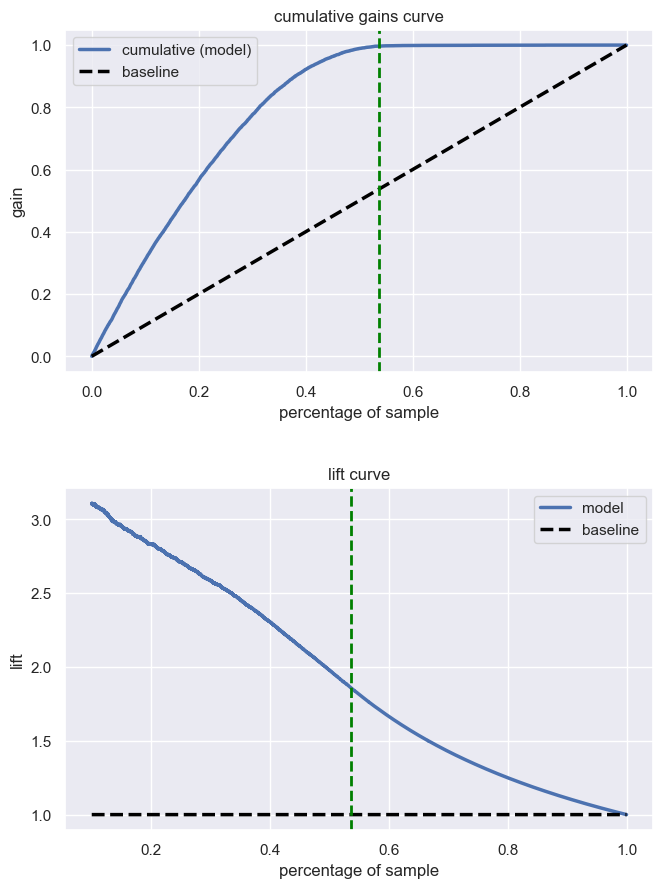


_______________________________ SCENARIO WITH 40000 PHONE CALLS _____________________________________________________________________________
By random list:
 - The sales team contacts 54% of those interested in car insurance: 4838 customers (see Gain: intersection black x green line).
  ==>  Estimated revenue: 4838 * 4.273,83 = Rs 20.68M per year.

By sorted list (model):
 - The sales team contacts 100% of those interested in car insurance: 8979 customers (see Gain: intersection blue x green line).
  ==> Estimated revenue: 8979 * 4.273,83 = Rs 38.37M per year.

RESULT: The model is 1.86 times better than the random list (see Lift: intersection blue x green line). 
So the estimated revenue is 1.86 times higher than the random list: Rs 17.7M.


In [87]:
# Making metrics for best 40k 
percent_at_40k = 40000 / len(df9)
recall_at_40k, table_40k = precision_recall_at_k(df9, k=40000)
curves_at_40k = gain_lift_curve(y_pred, y_testm, axvline=percent_at_40k)

#Scenario with 40000 phone calls

randcus = (round( (40000 / df9.shape[0]*100 ) / 100 * (round(df9.loc[df9['response'] == 1].shape[0])) ))
profitrand = randcus * 4273.83
modcus = round( recall_at_40k[1]*100  / 100 * (df9.loc[df9['response'] == 1].shape[0]) )
profitmodel = modcus * 4273.83

print (f"\n_______________________________ SCENARIO WITH 40000 PHONE CALLS _____________________________________________________________________________")
print (f"By random list:")
print (f" - The sales team contacts {round(40000 / df9.shape[0]*100 )}% of those interested in car insurance: {randcus} customers (see Gain: intersection black x green line).\n  ==>  Estimated revenue: {randcus} * 4.273,83 = Rs {nm.numerize(profitrand)} per year.")       

print (f"\nBy sorted list (model):")
print (f" - The sales team contacts {round(recall_at_40k[1]*100)}% of those interested in car insurance: {modcus} customers (see Gain: intersection blue x green line).\n  ==> Estimated revenue: {modcus} * 4.273,83 = Rs {nm.numerize(profitmodel)} per year.")

print (f"\nRESULT: The model is {round(modcus / randcus ,2)} times better than the random list (see Lift: intersection blue x green line). \nSo the estimated revenue is {round(profitmodel / profitrand, 2)} times higher than the random list: Rs {nm.numerize(profitmodel - profitrand)}.")

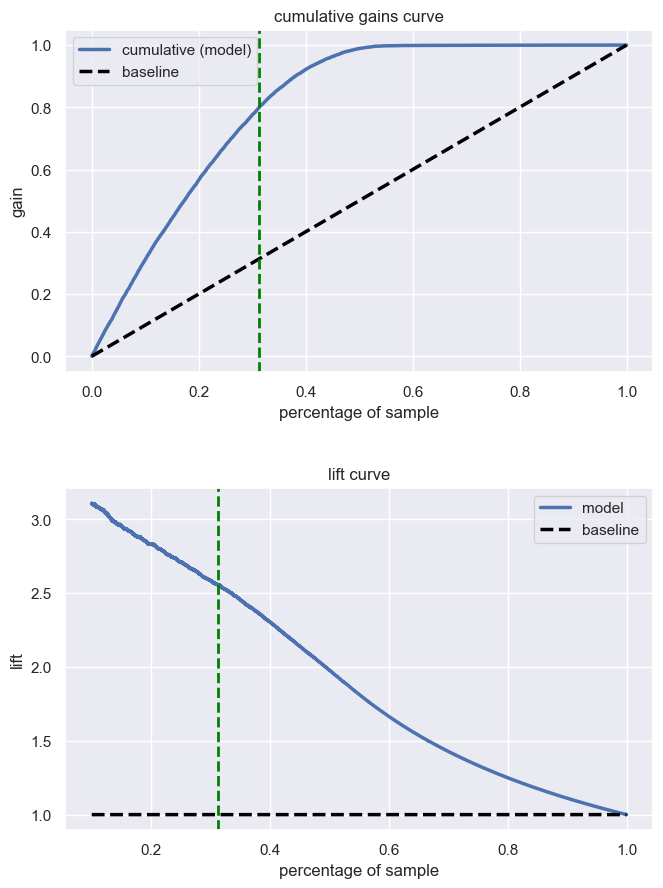


_______________________________ SCENARIO WITH 23300 PHONE CALLS _____________________________________________________________________________
By random list:
 - The sales team contacts 31% of those interested in car insurance: 2818 customers (see Gain: intersection black x green line).
  ==>  Estimated revenue: 2818 * 4.273,83 = Rs 12.04M per year.

By sorted list (model):
 - The sales team contacts 80% of those interested in car insurance: 7196 customers (see Gain: intersection blue x green line).
  ==> Estimated revenue: 7196 * 4.273,83 = Rs 30.75M per year.

RESULT: The model is 2.55 times better than the random list (see Lift: intersection blue x green line). 
So the estimated revenue is 2.55 times higher than the random list: Rs 18.71M.


In [90]:
# Making metrics for 80% of interest
percent_at_80 = 23300 / len(df9)
recall_at_80, table_80 = precision_recall_at_k(df9, k=23300)
curves_at_80 = gain_lift_curve(y_pred, y_testm, axvline=percent_at_80)

#Scenario with 23300 (80%) phone calls

randcus = (round( (23300 / df9.shape[0]*100 ) / 100 * (round(df9.loc[df9['response'] == 1].shape[0])) ))
profitrand = randcus * 4273.83
modcus = round( recall_at_80[1]*100  / 100 * (df9.loc[df9['response'] == 1].shape[0]) )
profitmodel = modcus * 4273.83

print (f"\n_______________________________ SCENARIO WITH 23300 PHONE CALLS _____________________________________________________________________________")
print (f"By random list:")
print (f" - The sales team contacts {round(23300 / df9.shape[0]*100 )}% of those interested in car insurance: {randcus} customers (see Gain: intersection black x green line).\n  ==>  Estimated revenue: {randcus} * 4.273,83 = Rs {nm.numerize(profitrand)} per year.")       

print (f"\nBy sorted list (model):")
print (f" - The sales team contacts {round(recall_at_80[1]*100)}% of those interested in car insurance: {modcus} customers (see Gain: intersection blue x green line).\n  ==> Estimated revenue: {modcus} * 4.273,83 = Rs {nm.numerize(profitmodel)} per year.")

print (f"\nRESULT: The model is {round(modcus / randcus ,2)} times better than the random list (see Lift: intersection blue x green line). \nSo the estimated revenue is {round(profitmodel / profitrand, 2)} times higher than the random list: Rs {nm.numerize(profitmodel - profitrand)}.")

# 10.0 Deploy model to production

In [ ]:
# Saving model
#pickle.dump(lgbm_model, open('../src/models/lgbm_model.pkl', 'wb'))

## 9.1 Health Insurance Class

In [ ]:
import json
import pickle
import numpy as np
import pandas as pd

class HealthInsurance:

    def __init__(self):
        self.annual_premium_scaler = pickle.load(open('../src/features/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler = pickle.load(open('../src/features/age_scaler.pkl', 'rb'))
        self.policy_sales_scaler = pickle.load(open('../src/features/fe_policy_sales_channel.pkl', 'rb'))
        self.target_encode_gender = pickle.load(open('../src/features/target_encode_gender.pkl', 'rb'))
        self.target_encode_region_code = pickle.load(open('../src/features/target_encode_region_code.pkl', 'rb'))
        self.vintage_scaler = pickle.load(open('../src/features/vintage_scaler.pkl', 'rb'))


    def data_cleaning(df1):
        # drop duplicates id columns
        df1 = df1.loc[:, ~df1.columns.duplicated()].copy()

        return df1


    def feature_engineering(df2):
        ## 2.3 Feature Engineering
        # adjust format into vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years'
                                                                else 'between_1_2_year' if x == '1-2 Year'
                                                                else 'below_1_year')


        # Convert categorical into numeric
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

        return df2


    def data_filtering(df3):
        ## 3.1 Filtragem das linhas
        # select only annual_premium bellow 65.000
        df3 = df3[df3['annual_premium'] < 65000]

        ## 3.2 Seleção das colunas

        # Select only who has driving license
        df3 = df3[df3['driving_license'] == 1]

        # drop driving license column
        df3.drop(columns='driving_license', inplace=True)

        return df3


    def data_preparation(self, df5):
        ## 5.1 Standardization

        # annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        ## 5.2 Rescaling

        # Age
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # Vintage
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        ## 5.3 Transformação
        ### 5.3.1 Encoding

        # gender - Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender)

        # region_code - Target Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code)

        # vehicle_age - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

        # policy_sales_channel - Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_scaler)

        # fillna
        df5 = df5.fillna(0)

        # select features from Metrics
        cols_selected = ['id', 'vintage', 'annual_premium', 'age', 'region_code',
                        'vehicle_damage', 'policy_sales_channel', 'previously_insured']


        return df5[cols_selected]
    

    def get_prediction(self, model, original_data, test_data):
        # results of train dataset
        pred = lgbm_model.predict_proba( test_data )

        # join prediction into original data
        original_data['score'] = pred

        return original_data.to_json(orient='record', date_format='iso')



## 9.2 Handler API

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from HealthInsurance import HealthInsurance

# loading model
model = pickle.load(open('../src/models/lgbm_model.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instance Health Insurance Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:
        return Response( 'please input a data', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)



## 9.3 API Tester

In [ ]:
import requests
import json

# loading test data
df_test = x_test
df_test['response'] = y_test

df_test = df_test.sample(50)

# convert data into json

data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
df_test

,id,gender,age,region_code,policy_sales_channel,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
80265,259571,Male,24,29.000,152.000,below_1_year,0,1,34965.000,146,0
371027,300153,Female,25,21.000,152.000,below_1_year,0,0,31052.000,192,0
313760,221274,Female,44,28.000,26.000,between_1_2_year,1,0,33797.000,234,1
99995,35240,Male,41,28.000,26.000,between_1_2_year,1,0,45214.000,167,0
366637,265658,Male,60,8.000,124.000,between_1_2_year,1,0,45253.000,256,0
146591,29289,Female,28,28.000,152.000,below_1_year,0,1,59118.000,257,0
250239,94281,Male,27,14.000,152.000,below_1_year,0,1,24655.000,231,0
4896,39434,Male,63,29.000,26.000,between_1_2_year,0,1,2630.000,85,0
16911,135289,Female,67,47.000,157.000,between_1_2_year,1,0,2630.000,91,0
187366,354411,Male,66,28.000,124.000,between_1_2_year,1,0,2630.000,62,1


In [ ]:
# Api call

#url = 'https://0.0.0.0:5000/predict'
url = 'https://health-insurance-ds.herokuapp.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status code {}'.format(r.status_code))

Status code 200


In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False)

,id,gender,age,region_code,policy_sales_channel,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,score
39,186131,Female,31,41.000,124.000,below_1_year,1,0,32176.000,219,1,0.999
11,88593,Male,59,28.000,124.000,over_2_years,1,0,43323.000,46,0,0.998
4,265658,Male,60,8.000,124.000,between_1_2_year,1,0,45253.000,256,0,0.998
16,274364,Female,61,28.000,124.000,between_1_2_year,1,0,53738.000,118,0,0.998
27,21129,Female,43,28.000,26.000,between_1_2_year,1,0,40317.000,237,1,0.996
3,35240,Male,41,28.000,26.000,between_1_2_year,1,0,45214.000,167,0,0.996
48,48069,Male,51,8.000,124.000,between_1_2_year,1,0,2630.000,223,0,0.995
2,221274,Female,44,28.000,26.000,between_1_2_year,1,0,33797.000,234,1,0.995
20,321537,Male,72,28.000,124.000,between_1_2_year,1,0,30012.000,273,0,0.994
9,354411,Male,66,28.000,124.000,between_1_2_year,1,0,2630.000,62,1,0.992


## 9.4 Results with new Customers

In [ ]:
# Import Health Insurance Class

import sys
import inflection

sys.path.insert(0, 'F:\SamuelOliveiraAlvesd\Desktop\Data_Science\Projetos\Health_Insurance_Cross_Sell\src\healthinsurance')

from HealthInsurance import HealthInsurance

In [ ]:
# Copy new test data
test_data_raw = pd.read_csv('../data/raw/test.csv', low_memory=False)


# rename columns
old_cols = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
            'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
            'Policy_Sales_Channel', 'Vintage']

snakecase = lambda x : inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

test_data_raw.columns = new_cols


# Instance Health Insurance Class
pipeline = HealthInsurance()

# data cleaning
df1 = pipeline.data_cleaning(test_data_raw)

# feature engineering
df2 = pipeline.feature_engineering(df1)

# data preparation
df3 = pipeline.data_preparation(df2)

# prediction
# results of train dataset
pred = lgbm_model.predict_proba( df3 )

# join prediction into original data
test_data_raw['score'] = pred[:, 1].tolist()

In [76]:
# organize score
test_data_raw.sort_values('score', ascending=False, inplace=True)
test_data_raw.head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
107943,489053,Male,55,1,28.000,0,> 2 Years,Yes,8792.000,52.000,110,0.987
53686,434796,Male,29,1,41.000,0,1-2 Year,Yes,12561.000,154.000,175,0.927
47068,428178,Female,33,1,28.000,0,< 1 Year,Yes,17697.000,124.000,167,0.922
43267,424377,Male,50,1,28.000,0,1-2 Year,Yes,17290.000,124.000,248,0.892
37791,418901,Female,32,1,52.000,0,< 1 Year,Yes,26121.000,124.000,18,0.892
76630,457740,Female,46,1,28.000,0,1-2 Year,Yes,17225.000,26.000,193,0.887
112339,493449,Male,31,1,51.000,0,1-2 Year,Yes,39600.000,163.000,192,0.884
11823,392933,Male,48,1,29.000,0,1-2 Year,Yes,15223.000,124.000,299,0.877
178,381288,Male,44,1,28.000,0,1-2 Year,Yes,18082.000,60.000,33,0.866
29869,410979,Male,38,1,28.000,0,1-2 Year,Yes,17958.000,26.000,37,0.864


In [74]:
# saving data
test_data_raw.to_csv('../data/processed/final_test_data.csv', index=False)